In [1]:
!pip install tensorflow
!pip install keras
!pip install KerasClassifier
!pip install swifter
!pip install emoji
!python -m spacy download en_core_web_md
from google.colab import drive
drive.mount('/content/drive')

ERROR: Could not find a version that satisfies the requirement KerasClassifier (from versions: none)
ERROR: No matching distribution found for KerasClassifier
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=f3ef4e2a42c935b952d6a4a9c9378955281095cd31825895d9ee9cb28def6761
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 25.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this

In [2]:
#Important imports to be added

import pandas as pd
import numpy as np
import re,nltk,swifter
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import tree
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import nltk
#downloading stopwords library from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
#reading csv and filling out missing values
rawdf = pd.read_csv(r'/content/drive/MyDrive/AML 2304/train-balanced-sarcasm.csv')

# Sampling to get balanced sarcastic and non-sarcastic samples
sarcastic_samples = rawdf[rawdf['label'] == 1].sample(n=3500, random_state=42)
non_sarcastic_samples = rawdf[rawdf['label'] == 0].sample(n=3500, random_state=42)

# Combining the samples to create a balanced dataset
df = pd.concat([sarcastic_samples, non_sarcastic_samples])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df = df.fillna('')

In [6]:
#taking only necessary comments
df = df[['label','comment','author','score','created_utc','parent_comment']]

In [7]:
df.head()

,label,comment,author,score,created_utc,parent_comment
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ..."
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.


**Exploratory Data Analysis**

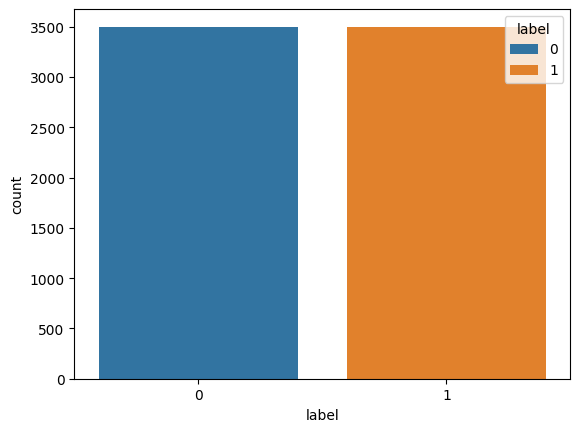

The percentage of Non-Sarcastic comments is 50.0
The percentage of Sarcastic comments is 50.0


In [8]:
import seaborn as sns
sns.countplot(x="label",data=df,hue="label")
plt.show()
print("The percentage of Non-Sarcastic comments is",sum(df['label']==0)/(len(df['label']))*100)
print("The percentage of Sarcastic comments is",sum(df['label']==1)/(len(df['label']))*100)

We can see from the countplot that this dataset is balanced

In [9]:
def clean_text(comment):

    # Cleaning the text by removing links, usernames, HTML tags, expansion of words, username removal, etc.
    text = str(comment)

    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)

    # Remove HTML tags
    text = re.sub("<.*?>", " ", text)

    # Remove numbers
    text = re.sub(r"[0-9]+", " ", text)

    # Remove reddit handles
    text = re.sub(r"@[A-Za-z0-9]+", " ", text)

    # Replace contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # Remove special characters
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')

    return text

# Apply text cleaning on comment and parent comment
df["cleanV1_comment"] = df["comment"].apply(clean_text)
df["cleanV1_parent_comment"] = df["parent_comment"].apply(clean_text)


In [10]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ..."
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.


In [11]:
#function to lowercase all except all caps word
def lowercase_except_caps(sentence):
  #print(sentence)
  words = sentence.split()
  modified_words = []
  for word in words:
    if word.isupper():
      modified_words.append(word)
    else:
      modified_words.append(word.lower())
  return " ".join(modified_words)

**Abbreviation Replacement**


In [12]:
#csv to dataframe
abbrslang=pd.read_csv(r'/content/drive/MyDrive/AML 2304/Abbr.csv')
abbrslang

,Abbr,Meaning
0,@TEOTD,At the end of the day
1,143,I love you
2,2G2BT,Too good to be true
3,404,I don't know
4,4EAE,Forever and ever
...,...,...
426,BS,Bullshit
427,NYC,New York City
428,VR,Virtual Reality
429,GTA,Grand Theft Auto


In [13]:
abbrslangDict=abbrslang.to_dict(orient='records')

In [14]:
import re
def expand_abbr(text, abbr_dict):
    # Regex for 2 or more capital letters (excluding common abbreviations)
    pattern1 = r"\b([A-Z]{2,}(?!\.[A-Z]{2,}))\b"

    # Regex for common abbreviations (Mr., Mrs., etc.)
    pattern2 = r"\b([A-Z]{2,}\.?)\b"

    # Combine both patterns
    combined_pattern = re.compile("|".join([pattern1, pattern2]))

    detected_abbr = []  # List to store detected abbreviations

    def expand_match(match):
        matched_abbr = match.group()
        detected_abbr.append(matched_abbr)  # Store detected abbreviation
        for entry in abbr_dict:
            if matched_abbr.upper() == entry['Abbr']:
                return entry['Meaning']
        return matched_abbr  # Use default if not found

    if not isinstance(text, str):
        text = str(text)  # Convert non-string inputs to strings

    expanded_text = combined_pattern.sub(expand_match, text)

    return expanded_text, detected_abbr

df['abbr_comment'], df['detected_abbr'] = zip(*df['cleanV1_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df['abbr_parent_comment'], df['detected_parent_abbr'] = zip(*df['cleanV1_parent_comment'].apply(expand_abbr, args=(abbrslangDict,)))
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],Consoles mainly play at fps. Peasants believe...,[PC]
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],No funny stories but I am a mid twenties virgi...,[]
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],"Facebook bans ChangeTip, tipping now possible ...",[]
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],So lemme get this right. Last game it was the ...,"[PF, WHATWELEARN]"
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],IT puts the lotion in the BASKET. Sheesh.,"[IT, BASKET]"


In [15]:
from collections import Counter
import pandas as pd

# Flatten the list of lists from detected_abbr and detected_parent_abbr columns into separate lists
detected_abbr_flat = [word for sublist in df['detected_abbr'] if sublist for word in sublist]
detected_parent_abbr_flat = [word for sublist in df['detected_parent_abbr'] if sublist for word in sublist]

# Count the frequency of each word in detected_abbr and detected_parent_abbr
abbr_freq = Counter(detected_abbr_flat)
parent_abbr_freq = Counter(detected_parent_abbr_flat)

# Convert the Counter objects to DataFrames
abbr_freq_df = pd.DataFrame.from_dict(abbr_freq, orient='index', columns=['abbr_comment_freq'])
parent_abbr_freq_df = pd.DataFrame.from_dict(parent_abbr_freq, orient='index', columns=['parent_abbr_comment_freq'])

# Reset the index to make the 'word' a column
abbr_freq_df.reset_index(inplace=True)
parent_abbr_freq_df.reset_index(inplace=True)

# Rename the 'index' column to 'comment_abbr' and 'parent_comment_abbr'
abbr_freq_df.rename(columns={'index': 'comment_abbr'}, inplace=True)
parent_abbr_freq_df.rename(columns={'index': 'parent_comment_abbr'}, inplace=True)

# Save the DataFrames to a CSV file
output_df = pd.concat([abbr_freq_df, parent_abbr_freq_df], axis=1)
output_df.to_csv('/content/drive/MyDrive/AML 2304/Abbr_word_frequency.csv', index=False)

In [16]:
df.to_csv('/content/drive/MyDrive/AML 2304/Abbr_log.csv', index=False)

In [17]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],Consoles mainly play at fps. Peasants believe...,[PC]
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],No funny stories but I am a mid twenties virgi...,[]
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],"Facebook bans ChangeTip, tipping now possible ...",[]
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],So lemme get this right. Last game it was the ...,"[PF, WHATWELEARN]"
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],IT puts the lotion in the BASKET. Sheesh.,"[IT, BASKET]"


# Slang Handling

In [18]:
import pandas as pd

# Load the CSV file into a DataFrame
slangs_df = pd.read_csv('/content/drive/MyDrive/AML 2304/Slangs.csv')

# Create a dictionary from the DataFrame
slangs_dict = dict(zip(slangs_df['slangs'], slangs_df['meanings']))

# Function to replace slangs in a sentence and store detected slangs
def replace_slangs(sentence):
    words = sentence.split()
    replaced_words = []
    detected_slangs = []
    for word in words:
        meaning = slangs_dict.get(word, word)
        if meaning != word:
            detected_slangs.append((word, meaning))
        replaced_words.append(meaning)
    return ' '.join(replaced_words), detected_slangs

df['slang_comment'], df['detected_slangs'] = zip(*df['abbr_comment'].apply(replace_slangs))
df['slang_parent_comment'], df['detected_parent_slangs'] = zip(*df['abbr_parent_comment'].apply(replace_slangs))

# Display the updated DataFrame
df.tail(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs
6990,0,U loyal,Peter_Olinto,5,2016-02-08 12:47:41,U smaht,U loyal,U smaht,U loyal,[],U smaht,[],U loyal,[],U smaht,[]
6991,1,"Yeah, my vote counts defintely show that",ECAkeris,3,2016-06-12 10:32:18,Its mostly been the transgenders doing a mini ...,"Yeah, my vote counts defintely show that",Its mostly been the transgenders doing a mini ...,"Yeah, my vote counts defintely show that",[],Its mostly been the transgenders doing a mini ...,[],"Yeah, my vote counts defintely show that",[],Its mostly been the transgenders doing a mini ...,[]
6992,0,Are those Model-Ms?,Pyrohair,2,2016-09-14 00:41:58,Absolutely Glorious work setup!,Are those Model-Ms?,Absolutely Glorious work setup!,Are those Model-Ms?,[],Absolutely Glorious work setup!,[],Are those Model-Ms?,[],Absolutely Glorious work setup!,[]
6993,0,"That would be honorable, you have my support.",kaskrinj,2,2016-02-02 21:26:24,"We should become a crime fighting duo, no arti...","That would be honorable, you have my support.","We should become a crime fighting duo, no arti...","That would be honorable, you have my support.",[],"We should become a crime fighting duo, no arti...",[],"That would be honorable, you have my support.",[],"We should become a crime fighting duo, no arti...",[]
6994,1,Laughing: a privilege for the rich.,k4ce,1,2016-01-08 23:36:23,Having a good time can be hard,Laughing: a privilege for the rich.,Having a good time can be hard,Laughing: a privilege for the rich.,[],Having a good time can be hard,[],Laughing: a privilege for the rich.,[],Having a good time can be hard,[]
6995,0,\#patriots,Duff_Lite,1,2016-09-07 16:18:09,Wow I thought #gobills was uncreative....,\#patriots,Wow I thought #gobills was uncreative....,\#patriots,[],Wow I thought #gobills was uncreative....,[],\#patriots,[],Wow I thought #gobills was uncreative....,[]
6996,0,I bet the IRS would love to see his back taxes...,Ser_Alliser_Thorne,2,2015-07-20 14:41:02,The relevant cartoon pinata. They're hoping if...,I bet the IRS would love to see his back taxes...,The relevant cartoon pinata. They are hoping i...,I bet the IRS would love to see his back taxes...,[IRS],The relevant cartoon pinata. They are hoping i...,[],I bet the IRS would love to see his back taxes...,[],The relevant cartoon pinata. They are hoping i...,[]
6997,0,I suppose the cdr caps as before but the dodge...,wagwanimal,1,2016-03-16 22:11:26,What does it do above 50? Give more CDR?,I suppose the cdr caps as before but the dodge...,What does it do above ? Give more CDR?,I suppose the cdr caps as before but the dodge...,[],What does it do above ? Give more CDR?,[CDR],I suppose the cdr caps as before but the dodge...,[],What does it do above ? Give more CDR?,[]
6998,0,Chicken Nuggets,PersianMG,9,2015-02-14 05:24:36,Would you happen to know the square root of va...,Chicken Nuggets,Would you happen to know the square root of va...,Chicken Nuggets,[],Would you happen to know the square root of va...,[],Chicken Nuggets,[],Would you happen to know the square root of va...,[]
6999,1,Yeah because it's really difficult to get guns...,AK47Uprising,14,2014-07-20 14:04:45,BREAKING: California Gov. Jerry Brown Signs Ne...,Yeah because it is really difficult to get gun...,BREAKING: California Gov. Jerry Brown Signs Ne...,Yeah because it is really difficult to get gun...,[],BREAKING: California Gov. Jerry Brown Signs Ne...,"[BREAKING, AB]",Yeah because it is really difficult to get gun...,[],BREAKING: California Gov. Jerry Brown Signs Ne...,[]


In [19]:
from collections import Counter
import pandas as pd

# Flatten the list of lists from detected_slangs and detected_parent_slangs columns into separate lists
detected_slang_flat = [word for sublist in df['detected_slangs'] if sublist for word in sublist]
detected_parent_slang_flat = [word for sublist in df['detected_parent_slangs'] if sublist for word in sublist]

# Count the frequency of each word in detected_slangs and detected_parent_slangs
slang_freq = Counter(detected_slang_flat)
parent_slang_freq = Counter(detected_parent_slang_flat)

# Convert the Counter objects to DataFrames
slang_freq_df = pd.DataFrame.from_dict(slang_freq, orient='index', columns=['slang_comment_freq'])
parent_slang_freq_df = pd.DataFrame.from_dict(parent_slang_freq, orient='index', columns=['parent_slang_comment_freq'])

# Reset the index to make the 'word' a column
slang_freq_df.reset_index(inplace=True)
parent_slang_freq_df.reset_index(inplace=True)

# Rename the 'index' column to 'comment_slangs' and 'parent_comment_slangs'
slang_freq_df.rename(columns={'index': 'comment_slangs'}, inplace=True)
parent_slang_freq_df.rename(columns={'index': 'parent_comment_slangs'}, inplace=True)

# Save the DataFrames to a CSV file
output_df = pd.concat([slang_freq_df, parent_slang_freq_df], axis=1)
output_df.to_csv('/content/drive/MyDrive/AML 2304/Slang_word_frequency.csv', index=False)

In [20]:
df.to_csv('/content/drive/MyDrive/AML 2304/Slang_log.csv', index=False)

In [21]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],Consoles mainly play at fps. Peasants believe...,[PC],"It started at fps, because that is what cinema...",[],Consoles mainly play at fps. Peasants believe ...,[]
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],No funny stories but I am a mid twenties virgi...,[],Your standards are just too high,[],No funny stories but I am a mid twenties virgi...,[]
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],"Facebook bans ChangeTip, tipping now possible ...",[],Facebook will be brought to justice in the day...,[],"Facebook bans ChangeTip, tipping now possible ...",[]
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],So lemme get this right. Last game it was the ...,"[PF, WHATWELEARN]",Apparently the refs still are rigging it!,[],So lemme get this right. Last game it was the ...,[]
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],IT puts the lotion in the BASKET. Sheesh.,"[IT, BASKET]","Dude, she puts the lotion on her SKIN, or else...",[],IT puts the lotion in the BASKET. Sheesh.,[]


In [22]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string

# Remove punctuation marks
df['punct_comment'] = df['slang_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
df['punct_parent_comment'] = df['slang_parent_comment'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation or char in ['?', '!','...']]))
# Tokenize the text
df['tokenized_comment'] = df['punct_comment'].apply(lambda x: word_tokenize(x))
df['tokenized_parent_comment'] = df['punct_parent_comment'].apply(lambda x: word_tokenize(x))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,abbr_parent_comment,detected_parent_abbr,slang_comment,detected_slangs,slang_parent_comment,detected_parent_slangs,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],Consoles mainly play at fps. Peasants believe...,[PC],"It started at fps, because that is what cinema...",[],Consoles mainly play at fps. Peasants believe ...,[],It started at fps because that is what cinemas...,Consoles mainly play at fps Peasants believe c...,"[It, started, at, fps, because, that, is, what...","[Consoles, mainly, play, at, fps, Peasants, be..."
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],No funny stories but I am a mid twenties virgi...,[],Your standards are just too high,[],No funny stories but I am a mid twenties virgi...,[],Your standards are just too high,No funny stories but I am a mid twenties virgi...,"[Your, standards, are, just, too, high]","[No, funny, stories, but, I, am, a, mid, twent..."
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],"Facebook bans ChangeTip, tipping now possible ...",[],Facebook will be brought to justice in the day...,[],"Facebook bans ChangeTip, tipping now possible ...",[],Facebook will be brought to justice in the day...,Facebook bans ChangeTip tipping now possible o...,"[Facebook, will, be, brought, to, justice, in,...","[Facebook, bans, ChangeTip, tipping, now, poss..."
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],So lemme get this right. Last game it was the ...,"[PF, WHATWELEARN]",Apparently the refs still are rigging it!,[],So lemme get this right. Last game it was the ...,[],Apparently the refs still are rigging it!,So lemme get this right Last game it was the r...,"[Apparently, the, refs, still, are, rigging, i...","[So, lem, me, get, this, right, Last, game, it..."
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],IT puts the lotion in the BASKET. Sheesh.,"[IT, BASKET]","Dude, she puts the lotion on her SKIN, or else...",[],IT puts the lotion in the BASKET. Sheesh.,[],Dude she puts the lotion on her SKIN or else I...,IT puts the lotion in the BASKET Sheesh,"[Dude, she, puts, the, lotion, on, her, SKIN, ...","[IT, puts, the, lotion, in, the, BASKET, Sheesh]"
5,1,Right because it takes so much skill to ninja ...,Iced____0ut,1,2015-12-22 19:43:37,I mean by that logic you could call a nuclear ...,Right because it takes so much skill to ninja ...,I mean by that logic you could call a nuclear ...,Right because it takes so much skill to ninja ...,[],I mean by that logic you could call a nuclear ...,[],Right because it takes so much skill to ninja ...,[],I mean by that logic you could call a nuclear ...,[],Right because it takes so much skill to ninja ...,I mean by that logic you could call

In [24]:
import emoji
# Function to check if a string contains emojis
def has_emoji(text):
    #text = str(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

# Function to replace emojis with their meanings
def replace_emojis(text):
    return emoji.demojize(text)

# Apply emoji replacement and check for emojis
df["has_emoji"] = df["tokenized_comment"].astype(str).apply(has_emoji)
df["has_emoji_parent"] = df["tokenized_parent_comment"].astype(str).apply(has_emoji)

# Apply emoji replacement and create a pandas Series
emoji_replaced_series = df["tokenized_comment"].astype(str).apply(replace_emojis)
emoji_replaced_series_parent = df["tokenized_parent_comment"].astype(str).apply(replace_emojis)

# Assign the pandas Series to the DataFrame as a new column
df["emoji_replaced_comment"] = emoji_replaced_series
df["emoji_replaced_parent_comment"] = emoji_replaced_series_parent
print(type(df['emoji_replaced_comment']))
print(type(df['emoji_replaced_parent_comment']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [25]:
print(df['has_emoji'].value_counts()[False])
print(df['has_emoji_parent'].value_counts()[False])

7000
7000


**This upper value is same as the total number of comments, which shows that we don't have any emojis in the dataset**

In [26]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,slang_parent_comment,detected_parent_slangs,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],...,Consoles mainly play at fps. Peasants believe ...,[],It started at fps because that is what cinemas...,Consoles mainly play at fps Peasants believe c...,"[It, started, at, fps, because, that, is, what...","[Consoles, mainly, play, at, fps, Peasants, be...",False,False,"['It', 'started', 'at', 'fps', 'because', 'tha...","['Consoles', 'mainly', 'play', 'at', 'fps', 'P..."
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],...,No funny stories but I am a mid twenties virgi...,[],Your standards are just too high,No funny stories but I am a mid twenties virgi...,"[Your, standards, are, just, too, high]","[No, funny, stories, but, I, am, a, mid, twent...",False,False,"['Your', 'standards', 'are', 'just', 'too', 'h...","['No', 'funny', 'stories', 'but', 'I', 'am', '..."
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],...,"Facebook bans ChangeTip, tipping now possible ...",[],Facebook will be brought to justice in the day...,Facebook bans ChangeTip tipping now possible o...,"[Facebook, will, be, brought, to, justice, in,...","[Facebook, bans, ChangeTip, tipping, now, poss...",False,False,"['Facebook', 'will', 'be', 'brought', 'to', 'j...","['Facebook', 'bans', 'ChangeTip', 'tipping', '..."
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],...,So lemme get this right. Last game it was the ...,[],Apparently the refs still are rigging it!,So lemme get this right Last game it was the r...,"[Apparently, the, refs, still, are, rigging, i...","[So, lem, me, get, this, right, Last, game, it...",False,False,"['Apparently', 'the', 'refs', 'still', 'are', ...","['So', 'lem', 'me', 'get', 'this', 'right', 'L..."
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],...,IT puts the lotion in the BASKET. Sheesh.,[],Dude she puts the lotion on her SKIN or else I...,IT puts the lotion in the BASKET Sheesh,"[Dude, she, puts, the, lotion, on, her, SKIN, ...","[IT, puts, the, lotion, in, the, BASKET, Sheesh]",False,False,"['Dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '..."


**Lowercasing the tokenized comments and parent comments**

In [27]:
# Apply the lowercase_except_caps function to 'emoji_replaced_comment' column
df['lowered_comment'] = df['emoji_replaced_comment'].apply(lowercase_except_caps)

# Apply the lowercase_except_caps function to 'emoji_replaced_parent_comment' column
df['lowered_parent_comment'] = df['emoji_replaced_parent_comment'].apply(lowercase_except_caps)

In [28]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,punct_comment,punct_parent_comment,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],...,It started at fps because that is what cinemas...,Consoles mainly play at fps Peasants believe c...,"[It, started, at, fps, because, that, is, what...","[Consoles, mainly, play, at, fps, Peasants, be...",False,False,"['It', 'started', 'at', 'fps', 'because', 'tha...","['Consoles', 'mainly', 'play', 'at', 'fps', 'P...","['it', 'started', 'at', 'fps', 'because', 'tha...","['consoles', 'mainly', 'play', 'at', 'fps', 'p..."
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,"[Your, standards, are, just, too, high]","[No, funny, stories, but, I, am, a, mid, twent...",False,False,"['Your', 'standards', 'are', 'just', 'too', 'h...","['No', 'funny', 'stories', 'but', 'I', 'am', '...","['your', 'standards', 'are', 'just', 'too', 'h...","['no', 'funny', 'stories', 'but', 'I', 'am', '..."
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],...,Facebook will be brought to justice in the day...,Facebook bans ChangeTip tipping now possible o...,"[Facebook, will, be, brought, to, justice, in,...","[Facebook, bans, ChangeTip, tipping, now, poss...",False,False,"['Facebook', 'will', 'be', 'brought', 'to', 'j...","['Facebook', 'bans', 'ChangeTip', 'tipping', '...","['facebook', 'will', 'be', 'brought', 'to', 'j...","['facebook', 'bans', 'changetip', 'tipping', '..."
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],...,Apparently the refs still are rigging it!,So lemme get this right Last game it was the r...,"[Apparently, the, refs, still, are, rigging, i...","[So, lem, me, get, this, right, Last, game, it...",False,False,"['Apparently', 'the', 'refs', 'still', 'are', ...","['So', 'lem', 'me', 'get', 'this', 'right', 'L...","['apparently', 'the', 'refs', 'still', 'are', ...","['so', 'lem', 'me', 'get', 'this', 'right', 'l..."
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],...,Dude she puts the lotion on her SKIN or else I...,IT puts the lotion in the BASKET Sheesh,"[Dude, she, puts, the, lotion, on, her, SKIN, ...","[IT, puts, the, lotion, in, the, BASKET, Sheesh]",False,False,"['Dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '...","['dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '..."


**Stop words removal**

In [29]:
import ast
from nltk.corpus import stopwords

# Import stopwords and define custom set
stops = set(stopwords.words('english')) - {'no', 'not', 'nor', 'against', 'above', 'below', 'off', 'own'}

# Apply stopword removal to the emoji_replaced_comment column
def remove_stopwords(comment):
    return [word for word in ast.literal_eval(comment) if word.lower() not in stops]

df["cleaned_comment"] = df["lowered_comment"].apply(remove_stopwords)
df["cleaned_parent_comment"] = df["lowered_parent_comment"].apply(remove_stopwords)

In [30]:
df.head(5)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,tokenized_comment,tokenized_parent_comment,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],...,"[It, started, at, fps, because, that, is, what...","[Consoles, mainly, play, at, fps, Peasants, be...",False,False,"['It', 'started', 'at', 'fps', 'because', 'tha...","['Consoles', 'mainly', 'play', 'at', 'fps', 'P...","['it', 'started', 'at', 'fps', 'because', 'tha...","['consoles', 'mainly', 'play', 'at', 'fps', 'p...","[started, fps, cinemas, display, moved, consol...","[consoles, mainly, play, fps, peasants, believ..."
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],...,"[Your, standards, are, just, too, high]","[No, funny, stories, but, I, am, a, mid, twent...",False,False,"['Your', 'standards', 'are', 'just', 'too', 'h...","['No', 'funny', 'stories', 'but', 'I', 'am', '...","['your', 'standards', 'are', 'just', 'too', 'h...","['no', 'funny', 'stories', 'but', 'I', 'am', '...","[standards, high]","[no, funny, stories, mid, twenties, virgin, ye..."
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],...,"[Facebook, will, be, brought, to, justice, in,...","[Facebook, bans, ChangeTip, tipping, now, poss...",False,False,"['Facebook', 'will', 'be', 'brought', 'to', 'j...","['Facebook', 'bans', 'ChangeTip', 'tipping', '...","['facebook', 'will', 'be', 'brought', 'to', 'j...","['facebook', 'bans', 'changetip', 'tipping', '...","[facebook, brought, justice, day, reckoning, h...","[facebook, bans, changetip, tipping, possible,..."
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],...,"[Apparently, the, refs, still, are, rigging, i...","[So, lem, me, get, this, right, Last, game, it...",False,False,"['Apparently', 'the', 'refs', 'still', 'are', ...","['So', 'lem', 'me', 'get', 'this', 'right', 'L...","['apparently', 'the', 'refs', 'still', 'are', ...","['so', 'lem', 'me', 'get', 'this', 'right', 'l...","[apparently, refs, still, rigging, !]","[lem, get, right, last, game, refs, us, guys, ..."
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],...,"[Dude, she, puts, the, lotion, on, her, SKIN, ...","[IT, puts, the, lotion, in, the, BASKET, Sheesh]",False,False,"['Dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '...","['dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '...","[dude, puts, lotion, SKIN, else, fuck, dog]","[puts, lotion, BASKET, sheesh]"


**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories before cleaning**

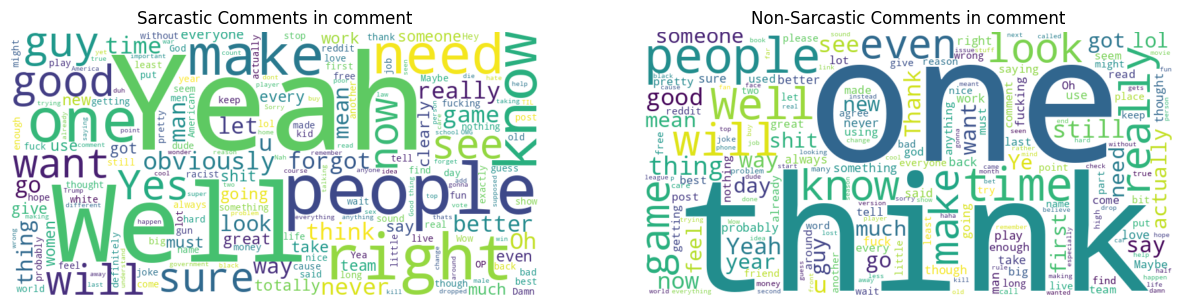

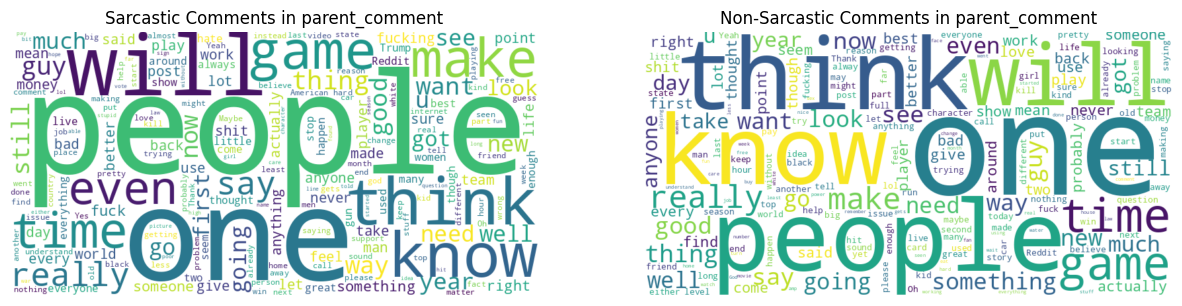

In [31]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter sarcastic and non-sarcastic comments in 'comment' column
sarcastic_comments = ' '.join(df[df['label'] == 1]['comment'])
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['comment'])

# Generate word clouds for sarcastic and non-sarcastic comments in 'comment' column
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds for 'comment'
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments in comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in comment')
plt.axis('off')

plt.show()

# Filter sarcastic and non-sarcastic comments in 'parent_comment' column
sarcastic_parent_comments = ' '.join(df[df['label'] == 1]['parent_comment'])
non_sarcastic_parent_comments = ' '.join(df[df['label'] == 0]['parent_comment'])

# Generate word clouds for sarcastic and non-sarcastic comments in 'parent_comment' column
wordcloud_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_parent_comments)
wordcloud_non_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_parent_comments)

# Plot the word clouds for 'parent_comment'
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic_parent, interpolation='bilinear')
plt.title('Sarcastic Comments in parent_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic_parent, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in parent_comment')
plt.axis('off')

plt.show()

**Cloud Map for highest occuring words in both(sarcastic & non-sarcastic) the categories after cleaning**

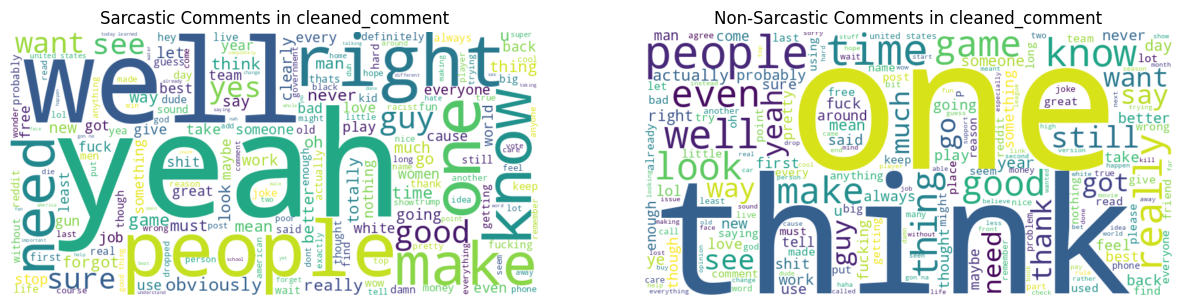

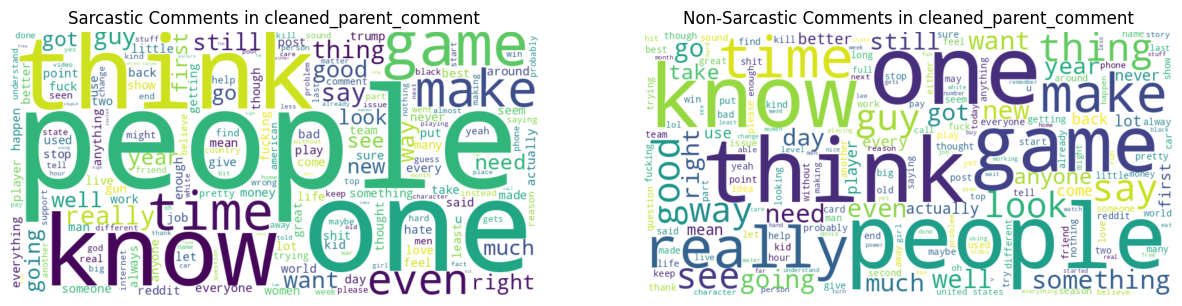

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join lists of words in cleaned_comment column to form strings
sarcastic_comments = ' '.join(df[df['label'] == 1]['cleaned_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_comments = ' '.join(df[df['label'] == 0]['cleaned_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments in cleaned_comment
wordcloud_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
wordcloud_non_sarcastic = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)

# Plot the word clouds for cleaned_comment
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic, interpolation='bilinear')
plt.title('Sarcastic Comments in cleaned_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in cleaned_comment')
plt.axis('off')

plt.show()

# Join lists of words in cleaned_parent_comment column to form strings
sarcastic_parent_comments = ' '.join(df[df['label'] == 1]['cleaned_parent_comment'].apply(lambda x: ' '.join(x)))
non_sarcastic_parent_comments = ' '.join(df[df['label'] == 0]['cleaned_parent_comment'].apply(lambda x: ' '.join(x)))

# Generate word clouds for sarcastic and non-sarcastic comments in cleaned_parent_comment
wordcloud_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_parent_comments)
wordcloud_non_sarcastic_parent = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_parent_comments)

# Plot the word clouds for cleaned_parent_comment
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic_parent, interpolation='bilinear')
plt.title('Sarcastic Comments in cleaned_parent_comment')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic_parent, interpolation='bilinear')
plt.title('Non-Sarcastic Comments in cleaned_parent_comment')
plt.axis('off')

plt.show()

**GloVe Embedding**

In [33]:
import spacy
import numpy as np

# Load SpaCy with GloVe vectors
nlp = spacy.load("en_core_web_md")  # Load the medium-sized English model with GloVe vectors

# Define function to compute average GloVe embeddings for a text
def compute_average_glove_embedding(text, nlp_model):
    doc = nlp_model(' '.join(text))
    # Get vectors for each token in the text
    word_vectors = [token.vector for token in doc if not token.is_stop]
    if word_vectors:
        # Compute average embedding
        average_embedding = np.mean(word_vectors, axis=0)
        return average_embedding
    else:
        # Return zeros if no valid word vectors found
        return np.zeros(nlp_model.vocab.vectors_length)

# Compute average GloVe embeddings for each comment
df['glove_embedding'] = df['cleaned_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))
df['glove_parent_embedding'] = df['cleaned_parent_comment'].apply(lambda x: compute_average_glove_embedding(x, nlp))

In [34]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,has_emoji,has_emoji_parent,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment,glove_embedding,glove_parent_embedding
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],...,False,False,"['It', 'started', 'at', 'fps', 'because', 'tha...","['Consoles', 'mainly', 'play', 'at', 'fps', 'P...","['it', 'started', 'at', 'fps', 'because', 'tha...","['consoles', 'mainly', 'play', 'at', 'fps', 'p...","[started, fps, cinemas, display, moved, consol...","[consoles, mainly, play, fps, peasants, believ...","[-0.5695712, 2.7343972, -1.8599586, 0.24222551...","[-0.7430894, 2.41309, -1.8888798, 1.0158342, 1..."
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],...,False,False,"['Your', 'standards', 'are', 'just', 'too', 'h...","['No', 'funny', 'stories', 'but', 'I', 'am', '...","['your', 'standards', 'are', 'just', 'too', 'h...","['no', 'funny', 'stories', 'but', 'I', 'am', '...","[standards, high]","[no, funny, stories, mid, twenties, virgin, ye...","[-1.060575, 1.2577, -0.18770003, 1.9933, 4.158...","[0.5911989, -0.21376221, -0.9432763, -0.429241..."
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],...,False,False,"['Facebook', 'will', 'be', 'brought', 'to', 'j...","['Facebook', 'bans', 'ChangeTip', 'tipping', '...","['facebook', 'will', 'be', 'brought', 'to', 'j...","['facebook', 'bans', 'changetip', 'tipping', '...","[facebook, brought, justice, day, reckoning, h...","[facebook, bans, changetip, tipping, possible,...","[-0.45191225, 0.11151777, -2.1923842, 0.003244...","[0.7485671, 0.45733145, -0.6915785, 1.0213158,..."
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],...,False,False,"['Apparently', 'the', 'refs', 'still', 'are', ...","['So', 'lem', 'me', 'get', 'this', 'right', 'L...","['apparently', 'the', 'refs', 'still', 'are', ...","['so', 'lem', 'me', 'get', 'this', 'right', 'l...","[apparently, refs, still, rigging, !]","[lem, get, right, last, game, refs, us, guys, ...","[-0.15972507, -1.29163, -0.2064774, -0.5069925...","[-1.3915477, 1.1287982, -0.7949294, -0.1688235..."
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],...,False,False,"['Dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '...","['dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '...","[dude, puts, lotion, SKIN, else, fuck, dog]","[puts, lotion, BASKET, sheesh]","[1.9631816, 0.39444348, -1.4379067, -2.7201233...","[0.49007004, -2.0434499, 0.36899996, 0.65825, ..."
5,1,Right because it takes so much skill to ninja ...,Iced____0ut,1,2015-12-22 19:43:37,I mean by that logic you could call a nuclear ...,Right because it takes so much skill to ninja ...,I mean by that

**lemmetization**

In [35]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_sm")

def lemma(comment):
    # Join the list of words into a single string
    text = ' '.join(comment)
    # Tokenize the text
    words = word_tokenize(text)
    # Lemmatize and remove stopwords
    cleaned_words = [token.lemma_ for token in nlp(' '.join(words)) if token.text not in stops]
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply lemmatization
df["lemma_comment"] = df["cleaned_comment"].apply(lemma)
df["lemma_parent_comment"] = df["cleaned_parent_comment"].apply(lemma)

In [36]:
df.head(10)

,label,comment,author,score,created_utc,parent_comment,cleanV1_comment,cleanV1_parent_comment,abbr_comment,detected_abbr,...,emoji_replaced_comment,emoji_replaced_parent_comment,lowered_comment,lowered_parent_comment,cleaned_comment,cleaned_parent_comment,glove_embedding,glove_parent_embedding,lemma_comment,lemma_parent_comment
0,0,"It started at 24 fps, because that's what cine...",kevtherev11,-1,2016-07-28 15:51:40,Consoles mainly play at 30fps. Peasants believ...,"It started at fps, because that is what cine...",Consoles mainly play at fps. Peasants believe...,"It started at fps, because that is what cine...",[],...,"['It', 'started', 'at', 'fps', 'because', 'tha...","['Consoles', 'mainly', 'play', 'at', 'fps', 'P...","['it', 'started', 'at', 'fps', 'because', 'tha...","['consoles', 'mainly', 'play', 'at', 'fps', 'p...","[started, fps, cinemas, display, moved, consol...","[consoles, mainly, play, fps, peasants, believ...","[-0.5695712, 2.7343972, -1.8599586, 0.24222551...","[-0.7430894, 2.41309, -1.8888798, 1.0158342, 1...",start fps cinemas display move console display...,console mainly play fps peasant believe consol...
1,1,Your standards are just too high,mareenah,4,2015-09-11 15:48:59,No funny stories but I am a mid twenties virgi...,Your standards are just too high,No funny stories but I am a mid twenties virgi...,Your standards are just too high,[],...,"['Your', 'standards', 'are', 'just', 'too', 'h...","['No', 'funny', 'stories', 'but', 'I', 'am', '...","['your', 'standards', 'are', 'just', 'too', 'h...","['no', 'funny', 'stories', 'but', 'I', 'am', '...","[standards, high]","[no, funny, stories, mid, twenties, virgin, ye...","[-1.060575, 1.2577, -0.18770003, 1.9933, 4.158...","[0.5911989, -0.21376221, -0.9432763, -0.429241...",standard high,no funny story mid twenty virgin yeah possible...
2,1,Facebook will be brought to justice in the day...,-who_is_john_galt-,5,2015-05-14 03:36:58,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,"Facebook bans ChangeTip, tipping now possible ...",Facebook will be brought to justice in the day...,[],...,"['Facebook', 'will', 'be', 'brought', 'to', 'j...","['Facebook', 'bans', 'ChangeTip', 'tipping', '...","['facebook', 'will', 'be', 'brought', 'to', 'j...","['facebook', 'bans', 'changetip', 'tipping', '...","[facebook, brought, justice, day, reckoning, h...","[facebook, bans, changetip, tipping, possible,...","[-0.45191225, 0.11151777, -2.1923842, 0.003244...","[0.7485671, 0.45733145, -0.6915785, 1.0213158,...",facebook bring justice day reckon hinder peopl...,facebook ban changetip tip possible private me...
3,1,Apparently the refs still are rigging it!,VanTil,1,2016-05-25 02:29:40,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,So lemme get this right. Last game it was the ...,Apparently the refs still are rigging it!,[],...,"['Apparently', 'the', 'refs', 'still', 'are', ...","['So', 'lem', 'me', 'get', 'this', 'right', 'L...","['apparently', 'the', 'refs', 'still', 'are', ...","['so', 'lem', 'me', 'get', 'this', 'right', 'l...","[apparently, refs, still, rigging, !]","[lem, get, right, last, game, refs, us, guys, ...","[-0.15972507, -1.29163, -0.2064774, -0.5069925...","[-1.3915477, 1.1287982, -0.7949294, -0.1688235...",apparently ref still rig !,lem get right last game ref we guy get free ki...
4,0,"Dude, she puts the lotion on her SKIN, or else...",fulfilledprophesy,2,2015-05-12 17:45:18,IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",IT puts the lotion in the BASKET. Sheesh.,"Dude, she puts the lotion on her SKIN, or else...",[SKIN],...,"['Dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '...","['dude', 'she', 'puts', 'the', 'lotion', 'on',...","['IT', 'puts', 'the', 'lotion', 'in', 'the', '...","[dude, puts, lotion, SKIN, else, fuck, dog]","[puts, lotion, BASKET, sheesh]","[1.9631816, 0.39

**TF-IDF Vectorization**

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer for 'lemma_comment'
vectorizer_comment = TfidfVectorizer()
TfIdfMatrix_comment = vectorizer_comment.fit_transform(df["lemma_comment"])
print(TfIdfMatrix_comment)
print("----------------------------------------------------------")
# Create TF-IDF vectorizer for 'lemma_parent_comment'
vectorizer_parent_comment = TfidfVectorizer()
TfIdfMatrix_parent_comment = vectorizer_parent_comment.fit_transform(df["lemma_parent_comment"])
print(TfIdfMatrix_parent_comment)

  (0, 6127)	0.19043246993957855
  (0, 6413)	0.3067830226291616
  (0, 1686)	0.3067830226291616
  (0, 5289)	0.2401094791537751
  (0, 2288)	0.6817586246719267
  (0, 1440)	0.34087931233596336
  (0, 3147)	0.29426248252212917
  (0, 7680)	0.2242037688197111
  (1, 3750)	0.6228988978740151
  (1, 7673)	0.7823023475788228
  (2, 7034)	0.4193491255254275
  (2, 3001)	0.2528307313415964
  (2, 5990)	0.19962264203825317
  (2, 3762)	0.3876188103186603
  (2, 6640)	0.4193491255254275
  (2, 2014)	0.2559460261884024
  (2, 4340)	0.33366332207193705
  (2, 1027)	0.3075453940091652
  (2, 2844)	0.35049672125461817
  (3, 6878)	0.5132232251256568
  (3, 7727)	0.358880218607389
  (3, 6672)	0.5868635540528577
  (3, 383)	0.5132232251256568
  (4, 2336)	0.3827045096546946
  (4, 3206)	0.30665240226199453
  :	:
  (6997, 6426)	0.37737067833452664
  (6997, 1284)	0.37737067833452664
  (6997, 7867)	0.27015365960986404
  (6997, 1206)	0.31107036763722345
  (6997, 2331)	0.3396243572475346
  (6997, 4019)	0.30714409344868665
  (69

**Concatinating GloVe Embedding Matrices and Tf-Idf Vectors horizontaly to create single feature Matrices**

In [38]:
from scipy.sparse import hstack, csr_matrix

# Convert the GloVe embeddings to CSR matrices for lemma_comment
glove_embeddings_comment = csr_matrix(np.vstack(df["glove_embedding"].values))
glove_embeddings_parent_comment = csr_matrix(np.vstack(df["glove_parent_embedding"].values))

# Combine the TF-IDF matrix and the GloVe embeddings for lemma_comment horizontally
combined_matrix_comment = hstack([TfIdfMatrix_comment, glove_embeddings_comment])

# Combine the TF-IDF matrix and the GloVe embeddings for lemma_parent_comment horizontally
combined_matrix_parent_comment = hstack([TfIdfMatrix_parent_comment, glove_embeddings_parent_comment])

# Print the shapes of the matrices
print("Combined matrix for lemma_comment shape:")
print("TfIdfMatrix shape:", TfIdfMatrix_comment.shape)
print("GloVe embeddings after csr shape:", glove_embeddings_comment.shape)
print("Combined matrix shape:", combined_matrix_comment.shape)

print("\nCombined matrix for lemma_parent_comment shape:")
print("TfIdfMatrix shape:", TfIdfMatrix_parent_comment.shape)
print("GloVe embeddings after csr shape:", glove_embeddings_parent_comment.shape)
print("Combined matrix parent shape:", combined_matrix_parent_comment.shape)

Combined matrix for lemma_comment shape:
TfIdfMatrix shape: (7000, 9119)
GloVe embeddings after csr shape: (7000, 300)
Combined matrix shape: (7000, 9419)

Combined matrix for lemma_parent_comment shape:
TfIdfMatrix shape: (7000, 14244)
GloVe embeddings after csr shape: (7000, 300)
Combined matrix parent shape: (7000, 14544)


In [39]:
print(combined_matrix_comment)
print("---------------------------------------------------")
print(combined_matrix_parent_comment)

  (0, 6127)	0.19043246993957855
  (0, 6413)	0.3067830226291616
  (0, 1686)	0.3067830226291616
  (0, 5289)	0.2401094791537751
  (0, 2288)	0.6817586246719267
  (0, 1440)	0.34087931233596336
  (0, 3147)	0.29426248252212917
  (0, 7680)	0.2242037688197111
  (0, 9119)	-0.5695711970329285
  (0, 9120)	2.7343971729278564
  (0, 9121)	-1.8599586486816406
  (0, 9122)	0.2422255128622055
  (0, 9123)	1.504770040512085
  (0, 9124)	1.7935278415679932
  (0, 9125)	0.4463101625442505
  (0, 9126)	2.7276220321655273
  (0, 9127)	-1.820433259010315
  (0, 9128)	-0.2631000280380249
  (0, 9129)	2.4836554527282715
  (0, 9130)	0.8279154300689697
  (0, 9131)	-4.1807332038879395
  (0, 9132)	2.344749927520752
  (0, 9133)	0.2945350706577301
  (0, 9134)	1.4988398551940918
  (0, 9135)	1.3473529815673828
  :	:
  (6999, 9394)	-0.08525873720645905
  (6999, 9395)	0.3694387674331665
  (6999, 9396)	-1.9647250175476074
  (6999, 9397)	-0.30582380294799805
  (6999, 9398)	1.8748185634613037
  (6999, 9399)	-0.24710002541542053
  (

In [40]:
# Combine the TF-IDF matrix and the GloVe embeddings for lemma_comment and lemma_parent_comment horizontally
combined_matrix_combined = hstack([combined_matrix_comment, combined_matrix_parent_comment])

# LSTM Model

In [41]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, ClassifierMixin

# 'labels' is a binary column indicating sarcasm (1) or not sarcasm (0)
X = combined_matrix_combined
y = df["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sparse matrix to dense array
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Reshape input data to be 3-dimensional for LSTM
X_train_reshaped = X_train_dense.reshape(X_train_dense.shape[0], 1, X_train_dense.shape[1])
X_test_reshaped = X_test_dense.reshape(X_test_dense.shape[0], 1, X_test_dense.shape[1])

# Define the custom LSTM classifier
class CustomLSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=20):
        self.epochs = epochs
        self.model = self.create_model()
        self.input_layer = self.model.input

    def create_model(self):
        model = Sequential([
            LSTM(64, input_shape=(1, X_train_dense.shape[1])),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=self.epochs, callbacks=[EarlyStopping(patience=3)])

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def extract_features(self, X):
        feature_extractor = Model(inputs=self.model.input, outputs=self.model.layers[0].output)
        return feature_extractor.predict(X)

    def get_params(self, deep=True):
        return {'epochs': self.epochs}

    def set_params(self, **params):
        self.epochs = params['epochs']
        self.model = self.create_model()
        return self

# Define the hyperparameters to search over
param_grid = {
    'epochs': [20, 50]
}

# Apply GridSearchCV with 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=CustomLSTMClassifier(), param_grid=param_grid, cv=kf, verbose=2)
grid_search_result = grid_search.fit(X_train_reshaped, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search_result.best_params_)

# Use the best estimator from GridSearchCV to make predictions
best_lstm_model = grid_search_result.best_estimator_
y_train_lstm_pred = best_lstm_model.predict(X_train_reshaped)
y_test_lstm_pred = best_lstm_model.predict(X_test_reshaped)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Epoch 1/20
138/140 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5469

140/140 [==============================] - 3s 4ms/step - loss: 0.6874 - accuracy: 0.5478
Epoch 2/20
140/140 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.6212

140/140 [==============================] - 1s 4ms/step - loss: 0.6482 - accuracy: 0.6212
Epoch 3/20
140/140 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.6868

140/140 [==============================] - 1s 4ms/step - loss: 0.5908 - accuracy: 0.6868
Epoch 4/20
128/140 [==========================>...] - ETA: 0s - loss: 0.5200 - accuracy: 0.7456

140/140 [==============================] - 1s 4ms/step - loss: 0.5209 - accuracy: 0.7458
Epoch 5/20
130/140 [==========================>...] - ETA: 0s - loss: 0.4373 - accuracy: 0.8132

140/140 [==============================] - 1s 4ms/step - loss: 0.4405 - accuracy: 0.8100
Epoch 6/20
129/140 [==========================>...] - ETA: 0s - loss: 0.3484 - accuracy: 0.8685

140/140 [==============================] - 1s 4ms/step - loss: 0.3511 - accuracy: 0.8685
Epoch 7/20
128/140 [==========================>...] - ETA: 0s - loss: 0.2559 - accuracy: 0.9260

140/140 [==============================] - 1s 4ms/step - loss: 0.2559 - accuracy: 0.9261
Epoch 8/20
140/140 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9567

140/140 [==============================] - 1s 4ms/step - loss: 0.1819 - accuracy: 0.9567
Epoch 9/20
131/140 [===========================>..] - ETA: 0s - loss: 0.1185 - accuracy: 0.9809

140/140 [==============================] - 1s 4ms/step - loss: 0.1180 - accuracy: 0.9804
Epoch 10/20
138/140 [============================>.] - ETA: 0s - loss: 0.0724 - accuracy: 0.9943

140/140 [==============================] - 1s 4ms/step - loss: 0.0726 - accuracy: 0.9942
Epoch 11/20
130/140 [==========================>...] - ETA: 0s - loss: 0.0441 - accuracy: 0.9981

140/140 [==============================] - 1s 4ms/step - loss: 0.0445 - accuracy: 0.9975
Epoch 12/20
130/140 [==========================>...] - ETA: 0s - loss: 0.0310 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0307 - accuracy: 0.9989
Epoch 13/20
138/140 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9975

140/140 [==============================] - 1s 4ms/step - loss: 0.0243 - accuracy: 0.9975
Epoch 14/20
139/140 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0159 - accuracy: 0.9991
Epoch 15/20
140/140 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9996

140/140 [==============================] - 1s 4ms/step - loss: 0.0125 - accuracy: 0.9996
Epoch 16/20
138/140 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0116 - accuracy: 0.9991
Epoch 17/20
135/140 [===========================>..] - ETA: 0s - loss: 0.0114 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0113 - accuracy: 0.9987
Epoch 18/20
135/140 [===========================>..] - ETA: 0s - loss: 0.0076 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0076 - accuracy: 0.9996
Epoch 19/20
137/140 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0073 - accuracy: 0.9996
Epoch 20/20
128/140 [==========================>...] - ETA: 0s - loss: 0.0055 - accuracy: 0.9998

35/35 [==============================] - 0s 2ms/step
[CV] END ..........................................epochs=20; total time=  17.2s
Epoch 1/20
128/140 [==========================>...] - ETA: 0s - loss: 0.6918 - accuracy: 0.5403

140/140 [==============================] - 2s 4ms/step - loss: 0.6896 - accuracy: 0.5460
Epoch 2/20
131/140 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6250

140/140 [==============================] - 1s 4ms/step - loss: 0.6478 - accuracy: 0.6241
Epoch 3/20
131/140 [===========================>..] - ETA: 0s - loss: 0.5986 - accuracy: 0.6794

140/140 [==============================] - 1s 4ms/step - loss: 0.5978 - accuracy: 0.6806
Epoch 4/20
130/140 [==========================>...] - ETA: 0s - loss: 0.5350 - accuracy: 0.7346

140/140 [==============================] - 1s 4ms/step - loss: 0.5328 - accuracy: 0.7359
Epoch 5/20
130/140 [==========================>...] - ETA: 0s - loss: 0.4622 - accuracy: 0.7918

140/140 [==============================] - 1s 4ms/step - loss: 0.4644 - accuracy: 0.7895
Epoch 6/20
129/140 [==========================>...] - ETA: 0s - loss: 0.3720 - accuracy: 0.8520

140/140 [==============================] - 1s 4ms/step - loss: 0.3732 - accuracy: 0.8507
Epoch 7/20
138/140 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.8965

140/140 [==============================] - 1s 4ms/step - loss: 0.2961 - accuracy: 0.8964
Epoch 8/20
137/140 [============================>.] - ETA: 0s - loss: 0.2118 - accuracy: 0.9443

140/140 [==============================] - 1s 4ms/step - loss: 0.2117 - accuracy: 0.9442
Epoch 9/20
139/140 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9696

140/140 [==============================] - 1s 4ms/step - loss: 0.1535 - accuracy: 0.9694
Epoch 10/20
137/140 [============================>.] - ETA: 0s - loss: 0.1022 - accuracy: 0.9879

140/140 [==============================] - 1s 4ms/step - loss: 0.1021 - accuracy: 0.9879
Epoch 11/20
140/140 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9960

140/140 [==============================] - 1s 4ms/step - loss: 0.0652 - accuracy: 0.9960
Epoch 12/20
132/140 [===========================>..] - ETA: 0s - loss: 0.0419 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0423 - accuracy: 0.9984
Epoch 13/20
129/140 [==========================>...] - ETA: 0s - loss: 0.0297 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0297 - accuracy: 0.9987
Epoch 14/20
130/140 [==========================>...] - ETA: 0s - loss: 0.0206 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0205 - accuracy: 0.9998
Epoch 15/20
131/140 [===========================>..] - ETA: 0s - loss: 0.0163 - accuracy: 0.9990

140/140 [==============================] - 1s 4ms/step - loss: 0.0164 - accuracy: 0.9989
Epoch 16/20
140/140 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9982

140/140 [==============================] - 1s 4ms/step - loss: 0.0142 - accuracy: 0.9982
Epoch 17/20
130/140 [==========================>...] - ETA: 0s - loss: 0.0109 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0110 - accuracy: 0.9998
Epoch 18/20
136/140 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000

140/140 [==============================] - 1s 4ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 19/20
131/140 [===========================>..] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000

140/140 [==============================] - 1s 4ms/step - loss: 0.0066 - accuracy: 0.9998
Epoch 20/20
128/140 [==========================>...] - ETA: 0s - loss: 0.0081 - accuracy: 0.9995

35/35 [==============================] - 0s 3ms/step
[CV] END ..........................................epochs=20; total time=  15.5s
Epoch 1/20
137/140 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.5525

140/140 [==============================] - 2s 4ms/step - loss: 0.6830 - accuracy: 0.5513
Epoch 2/20
136/140 [============================>.] - ETA: 0s - loss: 0.6296 - accuracy: 0.6388

140/140 [==============================] - 1s 4ms/step - loss: 0.6290 - accuracy: 0.6393
Epoch 3/20
134/140 [===========================>..] - ETA: 0s - loss: 0.5699 - accuracy: 0.7041

140/140 [==============================] - 1s 4ms/step - loss: 0.5711 - accuracy: 0.7031
Epoch 4/20
132/140 [===========================>..] - ETA: 0s - loss: 0.4923 - accuracy: 0.7694

140/140 [==============================] - 1s 4ms/step - loss: 0.4934 - accuracy: 0.7685
Epoch 5/20
134/140 [===========================>..] - ETA: 0s - loss: 0.4071 - accuracy: 0.8321

140/140 [==============================] - 1s 4ms/step - loss: 0.4074 - accuracy: 0.8321
Epoch 6/20
139/140 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.8833

140/140 [==============================] - 1s 4ms/step - loss: 0.3223 - accuracy: 0.8828
Epoch 7/20
128/140 [==========================>...] - ETA: 0s - loss: 0.2281 - accuracy: 0.9395

140/140 [==============================] - 1s 4ms/step - loss: 0.2270 - accuracy: 0.9388
Epoch 8/20
140/140 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9766

140/140 [==============================] - 1s 4ms/step - loss: 0.1493 - accuracy: 0.9766
Epoch 9/20
140/140 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9891

140/140 [==============================] - 1s 4ms/step - loss: 0.0987 - accuracy: 0.9891
Epoch 10/20
138/140 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9952

140/140 [==============================] - 1s 4ms/step - loss: 0.0637 - accuracy: 0.9953
Epoch 11/20
139/140 [============================>.] - ETA: 0s - loss: 0.0397 - accuracy: 0.9987

140/140 [==============================] - 1s 4ms/step - loss: 0.0396 - accuracy: 0.9987
Epoch 12/20
139/140 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0268 - accuracy: 0.9991
Epoch 13/20
137/140 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0205 - accuracy: 0.9996
Epoch 14/20
139/140 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0158 - accuracy: 0.9991
Epoch 15/20
129/140 [==========================>...] - ETA: 0s - loss: 0.0136 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0134 - accuracy: 0.9993
Epoch 16/20
131/140 [===========================>..] - ETA: 0s - loss: 0.0122 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0120 - accuracy: 0.9989
Epoch 17/20
130/140 [==========================>...] - ETA: 0s - loss: 0.0101 - accuracy: 0.9990

140/140 [==============================] - 1s 4ms/step - loss: 0.0102 - accuracy: 0.9989
Epoch 18/20
128/140 [==========================>...] - ETA: 0s - loss: 0.0084 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0081 - accuracy: 0.9996
Epoch 19/20
129/140 [==========================>...] - ETA: 0s - loss: 0.0063 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0065 - accuracy: 0.9998
Epoch 20/20
128/140 [==========================>...] - ETA: 0s - loss: 0.0055 - accuracy: 0.9998

35/35 [==============================] - 0s 3ms/step
[CV] END ..........................................epochs=20; total time=  15.7s
Epoch 1/20
128/140 [==========================>...] - ETA: 0s - loss: 0.6816 - accuracy: 0.5571

140/140 [==============================] - 2s 4ms/step - loss: 0.6787 - accuracy: 0.5636
Epoch 2/20
131/140 [===========================>..] - ETA: 0s - loss: 0.6220 - accuracy: 0.6484

140/140 [==============================] - 1s 4ms/step - loss: 0.6219 - accuracy: 0.6484
Epoch 3/20
139/140 [============================>.] - ETA: 0s - loss: 0.5670 - accuracy: 0.6974

140/140 [==============================] - 1s 4ms/step - loss: 0.5671 - accuracy: 0.6973
Epoch 4/20
128/140 [==========================>...] - ETA: 0s - loss: 0.4900 - accuracy: 0.7776

140/140 [==============================] - 1s 4ms/step - loss: 0.4925 - accuracy: 0.7754
Epoch 5/20
129/140 [==========================>...] - ETA: 0s - loss: 0.4288 - accuracy: 0.8135

140/140 [==============================] - 1s 4ms/step - loss: 0.4315 - accuracy: 0.8123
Epoch 6/20
132/140 [===========================>..] - ETA: 0s - loss: 0.3357 - accuracy: 0.8797

140/140 [==============================] - 1s 4ms/step - loss: 0.3363 - accuracy: 0.8779
Epoch 7/20
130/140 [==========================>...] - ETA: 0s - loss: 0.2506 - accuracy: 0.9245

140/140 [==============================] - 1s 4ms/step - loss: 0.2519 - accuracy: 0.9217
Epoch 8/20
129/140 [==========================>...] - ETA: 0s - loss: 0.1738 - accuracy: 0.9627

140/140 [==============================] - 1s 4ms/step - loss: 0.1741 - accuracy: 0.9634
Epoch 9/20
131/140 [===========================>..] - ETA: 0s - loss: 0.1151 - accuracy: 0.9843

140/140 [==============================] - 1s 4ms/step - loss: 0.1143 - accuracy: 0.9844
Epoch 10/20
131/140 [===========================>..] - ETA: 0s - loss: 0.0732 - accuracy: 0.9938

140/140 [==============================] - 1s 4ms/step - loss: 0.0731 - accuracy: 0.9937
Epoch 11/20
140/140 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9975

140/140 [==============================] - 1s 4ms/step - loss: 0.0481 - accuracy: 0.9975
Epoch 12/20
130/140 [==========================>...] - ETA: 0s - loss: 0.0320 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0318 - accuracy: 0.9987
Epoch 13/20
128/140 [==========================>...] - ETA: 0s - loss: 0.0218 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0226 - accuracy: 0.9987
Epoch 14/20
131/140 [===========================>..] - ETA: 0s - loss: 0.0183 - accuracy: 0.9983

140/140 [==============================] - 1s 4ms/step - loss: 0.0182 - accuracy: 0.9984
Epoch 15/20
128/140 [==========================>...] - ETA: 0s - loss: 0.0139 - accuracy: 0.9990

140/140 [==============================] - 1s 4ms/step - loss: 0.0140 - accuracy: 0.9989
Epoch 16/20
137/140 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0125 - accuracy: 0.9987
Epoch 17/20
134/140 [===========================>..] - ETA: 0s - loss: 0.0093 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0099 - accuracy: 0.9991
Epoch 18/20
133/140 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0099 - accuracy: 0.9993
Epoch 19/20
133/140 [===========================>..] - ETA: 0s - loss: 0.0064 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0065 - accuracy: 0.9996
Epoch 20/20
136/140 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9995

35/35 [==============================] - 0s 3ms/step
[CV] END ..........................................epochs=20; total time=  15.7s
Epoch 1/20
131/140 [===========================>..] - ETA: 0s - loss: 0.6810 - accuracy: 0.5625

140/140 [==============================] - 2s 4ms/step - loss: 0.6802 - accuracy: 0.5641
Epoch 2/20
131/140 [===========================>..] - ETA: 0s - loss: 0.6279 - accuracy: 0.6450

140/140 [==============================] - 1s 4ms/step - loss: 0.6277 - accuracy: 0.6440
Epoch 3/20
130/140 [==========================>...] - ETA: 0s - loss: 0.5677 - accuracy: 0.7067

140/140 [==============================] - 1s 4ms/step - loss: 0.5687 - accuracy: 0.7049
Epoch 4/20
132/140 [===========================>..] - ETA: 0s - loss: 0.4975 - accuracy: 0.7668

140/140 [==============================] - 1s 4ms/step - loss: 0.4986 - accuracy: 0.7656
Epoch 5/20
134/140 [===========================>..] - ETA: 0s - loss: 0.4282 - accuracy: 0.8172

140/140 [==============================] - 1s 4ms/step - loss: 0.4282 - accuracy: 0.8172
Epoch 6/20
133/140 [===========================>..] - ETA: 0s - loss: 0.3369 - accuracy: 0.8748

140/140 [==============================] - 1s 4ms/step - loss: 0.3375 - accuracy: 0.8750
Epoch 7/20
140/140 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9297

140/140 [==============================] - 1s 4ms/step - loss: 0.2450 - accuracy: 0.9297
Epoch 8/20
132/140 [===========================>..] - ETA: 0s - loss: 0.1738 - accuracy: 0.9643

140/140 [==============================] - 1s 4ms/step - loss: 0.1737 - accuracy: 0.9636
Epoch 9/20
129/140 [==========================>...] - ETA: 0s - loss: 0.1151 - accuracy: 0.9835

140/140 [==============================] - 1s 4ms/step - loss: 0.1151 - accuracy: 0.9842
Epoch 10/20
135/140 [===========================>..] - ETA: 0s - loss: 0.0766 - accuracy: 0.9919

140/140 [==============================] - 1s 4ms/step - loss: 0.0767 - accuracy: 0.9917
Epoch 11/20
137/140 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9964

140/140 [==============================] - 1s 4ms/step - loss: 0.0499 - accuracy: 0.9964
Epoch 12/20
137/140 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.9982

140/140 [==============================] - 1s 4ms/step - loss: 0.0327 - accuracy: 0.9982
Epoch 13/20
136/140 [============================>.] - ETA: 0s - loss: 0.0212 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0212 - accuracy: 0.9993
Epoch 14/20
140/140 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9987

140/140 [==============================] - 1s 4ms/step - loss: 0.0181 - accuracy: 0.9987
Epoch 15/20
140/140 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9984

140/140 [==============================] - 1s 4ms/step - loss: 0.0183 - accuracy: 0.9984
Epoch 16/20
131/140 [===========================>..] - ETA: 0s - loss: 0.0152 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0151 - accuracy: 0.9987
Epoch 17/20
132/140 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0104 - accuracy: 0.9993
Epoch 18/20
129/140 [==========================>...] - ETA: 0s - loss: 0.0099 - accuracy: 0.9990

140/140 [==============================] - 1s 4ms/step - loss: 0.0099 - accuracy: 0.9989
Epoch 19/20
129/140 [==========================>...] - ETA: 0s - loss: 0.0072 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0074 - accuracy: 0.9996
Epoch 20/20
131/140 [===========================>..] - ETA: 0s - loss: 0.0066 - accuracy: 0.9990

35/35 [==============================] - 0s 3ms/step
[CV] END ..........................................epochs=20; total time=  15.4s
Epoch 1/50
140/140 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5634

140/140 [==============================] - 2s 4ms/step - loss: 0.6799 - accuracy: 0.5634
Epoch 2/50
139/140 [============================>.] - ETA: 0s - loss: 0.6223 - accuracy: 0.6493

140/140 [==============================] - 1s 4ms/step - loss: 0.6228 - accuracy: 0.6484
Epoch 3/50
137/140 [============================>.] - ETA: 0s - loss: 0.5552 - accuracy: 0.7199

140/140 [==============================] - 1s 4ms/step - loss: 0.5575 - accuracy: 0.7165
Epoch 4/50
138/140 [============================>.] - ETA: 0s - loss: 0.4722 - accuracy: 0.7887

140/140 [==============================] - 1s 4ms/step - loss: 0.4730 - accuracy: 0.7879
Epoch 5/50
137/140 [============================>.] - ETA: 0s - loss: 0.3868 - accuracy: 0.8481

140/140 [==============================] - 1s 4ms/step - loss: 0.3869 - accuracy: 0.8475
Epoch 6/50
139/140 [============================>.] - ETA: 0s - loss: 0.2976 - accuracy: 0.9009

140/140 [==============================] - 1s 4ms/step - loss: 0.2970 - accuracy: 0.9013
Epoch 7/50
138/140 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9468

140/140 [==============================] - 1s 4ms/step - loss: 0.2106 - accuracy: 0.9467
Epoch 8/50
130/140 [==========================>...] - ETA: 0s - loss: 0.1337 - accuracy: 0.9776

140/140 [==============================] - 1s 4ms/step - loss: 0.1352 - accuracy: 0.9766
Epoch 9/50
137/140 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9895

140/140 [==============================] - 1s 4ms/step - loss: 0.0909 - accuracy: 0.9897
Epoch 10/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0572 - accuracy: 0.9957

140/140 [==============================] - 1s 4ms/step - loss: 0.0567 - accuracy: 0.9960
Epoch 11/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0381 - accuracy: 0.9971

140/140 [==============================] - 1s 4ms/step - loss: 0.0392 - accuracy: 0.9967
Epoch 12/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0271 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0271 - accuracy: 0.9989
Epoch 13/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0183 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0187 - accuracy: 0.9987
Epoch 14/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0170 - accuracy: 0.9981

140/140 [==============================] - 1s 4ms/step - loss: 0.0167 - accuracy: 0.9982
Epoch 15/50
128/140 [==========================>...] - ETA: 0s - loss: 0.0119 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0119 - accuracy: 0.9998
Epoch 16/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0111 - accuracy: 0.9989
Epoch 17/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9990

140/140 [==============================] - 1s 4ms/step - loss: 0.0100 - accuracy: 0.9991
Epoch 18/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0091 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0089 - accuracy: 0.9993
Epoch 19/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0069 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0068 - accuracy: 0.9996
Epoch 20/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0082 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0084 - accuracy: 0.9984
Epoch 21/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0079 - accuracy: 0.9983

140/140 [==============================] - 1s 4ms/step - loss: 0.0079 - accuracy: 0.9984
Epoch 22/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0074 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0073 - accuracy: 0.9989
Epoch 23/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0075 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0072 - accuracy: 0.9987
Epoch 24/50
136/140 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0063 - accuracy: 0.9991
Epoch 25/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0286 - accuracy: 0.9914

140/140 [==============================] - 1s 4ms/step - loss: 0.0328 - accuracy: 0.9897
Epoch 26/50
136/140 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9442

140/140 [==============================] - 1s 4ms/step - loss: 0.1585 - accuracy: 0.9446
Epoch 27/50
139/140 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9854

140/140 [==============================] - 1s 4ms/step - loss: 0.0642 - accuracy: 0.9855
Epoch 28/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0180 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0179 - accuracy: 0.9993
Epoch 29/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0070 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0070 - accuracy: 0.9996
Epoch 30/50
140/140 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9996

140/140 [==============================] - 1s 4ms/step - loss: 0.0048 - accuracy: 0.9996
Epoch 31/50
140/140 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0041 - accuracy: 0.9998
Epoch 32/50
128/140 [==========================>...] - ETA: 0s - loss: 0.0030 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0036 - accuracy: 0.9993
Epoch 33/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0053 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0051 - accuracy: 0.9989
Epoch 34/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0053 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0050 - accuracy: 0.9993
Epoch 35/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0032 - accuracy: 0.9996
Epoch 36/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0033 - accuracy: 0.9993
Epoch 37/50
140/140 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0023 - accuracy: 0.9998
Epoch 38/50
140/140 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

140/140 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 39/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0021 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.9998
Epoch 40/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0028 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 41/50
132/140 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9996
Epoch 42/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0015 - accuracy: 0.9998
Epoch 43/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0019 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 44/50
138/140 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0017 - accuracy: 0.9998
Epoch 45/50
137/140 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.9996
Epoch 46/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0017 - accuracy: 0.9998
Epoch 47/50
140/140 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

140/140 [==============================] - 1s 4ms/step - loss: 0.0043 - accuracy: 0.9989
Epoch 48/50
135/140 [===========================>..] - ETA: 0s - loss: 0.1046 - accuracy: 0.9609

140/140 [==============================] - 1s 4ms/step - loss: 0.1098 - accuracy: 0.9587
Epoch 49/50
129/140 [==========================>...] - ETA: 0s - loss: 0.1473 - accuracy: 0.9453

140/140 [==============================] - 1s 4ms/step - loss: 0.1448 - accuracy: 0.9460
Epoch 50/50
128/140 [==========================>...] - ETA: 0s - loss: 0.0437 - accuracy: 0.9905

35/35 [==============================] - 0s 3ms/step
[CV] END ..........................................epochs=50; total time=  33.0s
Epoch 1/50
128/140 [==========================>...] - ETA: 0s - loss: 0.6816 - accuracy: 0.5527

140/140 [==============================] - 2s 4ms/step - loss: 0.6821 - accuracy: 0.5536
Epoch 2/50
131/140 [===========================>..] - ETA: 0s - loss: 0.6272 - accuracy: 0.6517

140/140 [==============================] - 1s 4ms/step - loss: 0.6268 - accuracy: 0.6509
Epoch 3/50
130/140 [==========================>...] - ETA: 0s - loss: 0.5604 - accuracy: 0.7216

140/140 [==============================] - 1s 4ms/step - loss: 0.5614 - accuracy: 0.7210
Epoch 4/50
131/140 [===========================>..] - ETA: 0s - loss: 0.4922 - accuracy: 0.7672

140/140 [==============================] - 1s 4ms/step - loss: 0.4942 - accuracy: 0.7652
Epoch 5/50
132/140 [===========================>..] - ETA: 0s - loss: 0.4131 - accuracy: 0.8274

140/140 [==============================] - 1s 4ms/step - loss: 0.4123 - accuracy: 0.8266
Epoch 6/50
132/140 [===========================>..] - ETA: 0s - loss: 0.3248 - accuracy: 0.8769

140/140 [==============================] - 1s 4ms/step - loss: 0.3243 - accuracy: 0.8772
Epoch 7/50
129/140 [==========================>...] - ETA: 0s - loss: 0.2366 - accuracy: 0.9329

140/140 [==============================] - 1s 4ms/step - loss: 0.2369 - accuracy: 0.9326
Epoch 8/50
136/140 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.9733

140/140 [==============================] - 1s 4ms/step - loss: 0.1484 - accuracy: 0.9730
Epoch 9/50
137/140 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9879

140/140 [==============================] - 1s 4ms/step - loss: 0.0972 - accuracy: 0.9882
Epoch 10/50
137/140 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9954

140/140 [==============================] - 1s 4ms/step - loss: 0.0619 - accuracy: 0.9955
Epoch 11/50
135/140 [===========================>..] - ETA: 0s - loss: 0.0398 - accuracy: 0.9984

140/140 [==============================] - 1s 4ms/step - loss: 0.0396 - accuracy: 0.9984
Epoch 12/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0265 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9996
Epoch 13/50
140/140 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9989

140/140 [==============================] - 1s 4ms/step - loss: 0.0202 - accuracy: 0.9989
Epoch 14/50
132/140 [===========================>..] - ETA: 0s - loss: 0.0137 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0137 - accuracy: 0.9996
Epoch 15/50
127/140 [==========================>...] - ETA: 0s - loss: 0.0109 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0109 - accuracy: 0.9998
Epoch 16/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0096 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0097 - accuracy: 0.9996
Epoch 17/50
140/140 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0074 - accuracy: 0.9998
Epoch 18/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0100 - accuracy: 0.9983

140/140 [==============================] - 1s 4ms/step - loss: 0.0104 - accuracy: 0.9980
Epoch 19/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0075 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0074 - accuracy: 0.9998
Epoch 20/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0059 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0059 - accuracy: 0.9993
Epoch 21/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0047 - accuracy: 0.9993
Epoch 22/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0064 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0064 - accuracy: 0.9993
Epoch 23/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0060 - accuracy: 0.9989
Epoch 24/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0062 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0064 - accuracy: 0.9989
Epoch 25/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0074 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0074 - accuracy: 0.9989
Epoch 26/50
139/140 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9996

140/140 [==============================] - 1s 4ms/step - loss: 0.0046 - accuracy: 0.9996
Epoch 27/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0068 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0066 - accuracy: 0.9989
Epoch 28/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0095 - accuracy: 0.9990

140/140 [==============================] - 1s 4ms/step - loss: 0.0110 - accuracy: 0.9989
Epoch 29/50
130/140 [==========================>...] - ETA: 0s - loss: 0.2000 - accuracy: 0.9197

140/140 [==============================] - 1s 4ms/step - loss: 0.2026 - accuracy: 0.9174
Epoch 30/50
130/140 [==========================>...] - ETA: 0s - loss: 0.1374 - accuracy: 0.9543

140/140 [==============================] - 1s 4ms/step - loss: 0.1382 - accuracy: 0.9520
Epoch 31/50
138/140 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9898

140/140 [==============================] - 1s 4ms/step - loss: 0.0472 - accuracy: 0.9895
Epoch 32/50
133/140 [===========================>..] - ETA: 0s - loss: 0.0165 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0162 - accuracy: 0.9991
Epoch 33/50
137/140 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0069 - accuracy: 0.9998
Epoch 34/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0052 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0052 - accuracy: 0.9998
Epoch 35/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0038 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0038 - accuracy: 0.9998
Epoch 36/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

140/140 [==============================] - 1s 4ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 37/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0028 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0028 - accuracy: 0.9998
Epoch 38/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0026 - accuracy: 0.9998
Epoch 39/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0027 - accuracy: 0.9996
Epoch 40/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0031 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0030 - accuracy: 0.9998
Epoch 41/50
132/140 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

140/140 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 42/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0024 - accuracy: 0.9996
Epoch 43/50
135/140 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

140/140 [==============================] - 1s 4ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 44/50
132/140 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0023 - accuracy: 0.9996
Epoch 45/50
128/140 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.9996
Epoch 46/50
140/140 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0017 - accuracy: 0.9998
Epoch 47/50
136/140 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.9996
Epoch 48/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0020 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 49/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0012 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 50/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 0.9995

35/35 [==============================] - 0s 3ms/step
[CV] END ..........................................epochs=50; total time=  32.7s
Epoch 1/50
130/140 [==========================>...] - ETA: 0s - loss: 0.6811 - accuracy: 0.5572

140/140 [==============================] - 2s 4ms/step - loss: 0.6800 - accuracy: 0.5592
Epoch 2/50
131/140 [===========================>..] - ETA: 0s - loss: 0.6257 - accuracy: 0.6529

140/140 [==============================] - 1s 4ms/step - loss: 0.6259 - accuracy: 0.6527
Epoch 3/50
131/140 [===========================>..] - ETA: 0s - loss: 0.5536 - accuracy: 0.7207

140/140 [==============================] - 1s 4ms/step - loss: 0.5543 - accuracy: 0.7214
Epoch 4/50
132/140 [===========================>..] - ETA: 0s - loss: 0.4810 - accuracy: 0.7727

140/140 [==============================] - 1s 4ms/step - loss: 0.4826 - accuracy: 0.7717
Epoch 5/50
132/140 [===========================>..] - ETA: 0s - loss: 0.3897 - accuracy: 0.8421

140/140 [==============================] - 1s 4ms/step - loss: 0.3928 - accuracy: 0.8395
Epoch 6/50
131/140 [===========================>..] - ETA: 0s - loss: 0.3061 - accuracy: 0.8850

140/140 [==============================] - 1s 4ms/step - loss: 0.3043 - accuracy: 0.8862
Epoch 7/50
132/140 [===========================>..] - ETA: 0s - loss: 0.2091 - accuracy: 0.9477

140/140 [==============================] - 1s 4ms/step - loss: 0.2089 - accuracy: 0.9482
Epoch 8/50
130/140 [==========================>...] - ETA: 0s - loss: 0.1441 - accuracy: 0.9724

140/140 [==============================] - 1s 4ms/step - loss: 0.1432 - accuracy: 0.9721
Epoch 9/50
140/140 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9886

140/140 [==============================] - 1s 4ms/step - loss: 0.0915 - accuracy: 0.9886
Epoch 10/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0544 - accuracy: 0.9956

140/140 [==============================] - 1s 4ms/step - loss: 0.0543 - accuracy: 0.9958
Epoch 11/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0328 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0329 - accuracy: 0.9991
Epoch 12/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0241 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0243 - accuracy: 0.9991
Epoch 13/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0172 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0172 - accuracy: 0.9998
Epoch 14/50
139/140 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0141 - accuracy: 0.9991
Epoch 15/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0100 - accuracy: 0.9998
Epoch 16/50
138/140 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0084 - accuracy: 0.9998
Epoch 17/50
136/140 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0071 - accuracy: 0.9996
Epoch 18/50
138/140 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0058 - accuracy: 0.9998
Epoch 19/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0063 - accuracy: 0.9996
Epoch 20/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0046 - accuracy: 0.9996
Epoch 21/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0035 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0035 - accuracy: 0.9998
Epoch 22/50
132/140 [===========================>..] - ETA: 0s - loss: 0.0034 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0033 - accuracy: 0.9998
Epoch 23/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 0.9998
Epoch 24/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0025 - accuracy: 0.9998
Epoch 25/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9998
Epoch 26/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.9998
Epoch 27/50
140/140 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 28/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.9998
Epoch 29/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 30/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 31/50
133/140 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 32/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 33/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 34/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 35/50
140/140 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998    

140/140 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.9998
Epoch 36/50
129/140 [==========================>...] - ETA: 0s - loss: 6.5647e-04 - accuracy: 1.0000

140/140 [==============================] - 1s 4ms/step - loss: 9.8702e-04 - accuracy: 0.9998
Epoch 37/50
137/140 [============================>.] - ETA: 0s - loss: 9.1511e-04 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 9.1200e-04 - accuracy: 0.9998
Epoch 38/50
139/140 [============================>.] - ETA: 0s - loss: 9.3426e-04 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 9.3026e-04 - accuracy: 0.9998
Epoch 39/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.9998
Epoch 40/50
131/140 [===========================>..] - ETA: 0s - loss: 8.9062e-04 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 9.4861e-04 - accuracy: 0.9998
Epoch 41/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 42/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0012 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 43/50
130/140 [==========================>...] - ETA: 0s - loss: 8.9895e-04 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 8.6434e-04 - accuracy: 0.9998
Epoch 44/50
132/140 [===========================>..] - ETA: 0s - loss: 8.2334e-04 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 7.9956e-04 - accuracy: 0.9998
Epoch 45/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.9998
Epoch 46/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 9.7854e-04 - accuracy: 0.9998
Epoch 47/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 48/50
128/140 [==========================>...] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 9.5839e-04 - accuracy: 0.9998
Epoch 49/50
140/140 [==============================] - ETA: 0s - loss: 7.8570e-04 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 7.8570e-04 - accuracy: 0.9998
Epoch 50/50
130/140 [==========================>...] - ETA: 0s - loss: 2.2398e-04 - accuracy: 1.0000

35/35 [==============================] - 0s 3ms/step
[CV] END ..........................................epochs=50; total time=  32.7s
Epoch 1/50
137/140 [============================>.] - ETA: 0s - loss: 0.6815 - accuracy: 0.5641

140/140 [==============================] - 2s 4ms/step - loss: 0.6823 - accuracy: 0.5629
Epoch 2/50
136/140 [============================>.] - ETA: 0s - loss: 0.6296 - accuracy: 0.6429

140/140 [==============================] - 1s 4ms/step - loss: 0.6298 - accuracy: 0.6417
Epoch 3/50
128/140 [==========================>...] - ETA: 0s - loss: 0.5756 - accuracy: 0.7073

140/140 [==============================] - 1s 4ms/step - loss: 0.5761 - accuracy: 0.7092
Epoch 4/50
128/140 [==========================>...] - ETA: 0s - loss: 0.5024 - accuracy: 0.7612

140/140 [==============================] - 1s 4ms/step - loss: 0.5030 - accuracy: 0.7594
Epoch 5/50
128/140 [==========================>...] - ETA: 0s - loss: 0.4212 - accuracy: 0.8206

140/140 [==============================] - 1s 4ms/step - loss: 0.4241 - accuracy: 0.8167
Epoch 6/50
129/140 [==========================>...] - ETA: 0s - loss: 0.3261 - accuracy: 0.8813

140/140 [==============================] - 1s 4ms/step - loss: 0.3248 - accuracy: 0.8830
Epoch 7/50
130/140 [==========================>...] - ETA: 0s - loss: 0.2340 - accuracy: 0.9353

140/140 [==============================] - 1s 4ms/step - loss: 0.2364 - accuracy: 0.9333
Epoch 8/50
136/140 [============================>.] - ETA: 0s - loss: 0.1665 - accuracy: 0.9648

140/140 [==============================] - 1s 4ms/step - loss: 0.1661 - accuracy: 0.9650
Epoch 9/50
139/140 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9865

140/140 [==============================] - 1s 4ms/step - loss: 0.1051 - accuracy: 0.9866
Epoch 10/50
137/140 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9943

140/140 [==============================] - 1s 4ms/step - loss: 0.0687 - accuracy: 0.9944
Epoch 11/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0434 - accuracy: 0.9974

140/140 [==============================] - 1s 4ms/step - loss: 0.0434 - accuracy: 0.9975
Epoch 12/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0270 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0280 - accuracy: 0.9987
Epoch 13/50
138/140 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.9977

140/140 [==============================] - 1s 4ms/step - loss: 0.0240 - accuracy: 0.9978
Epoch 14/50
139/140 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 0.9987

140/140 [==============================] - 1s 4ms/step - loss: 0.0164 - accuracy: 0.9987
Epoch 15/50
140/140 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0125 - accuracy: 0.9991
Epoch 16/50
137/140 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0114 - accuracy: 0.9996
Epoch 17/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0094 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0095 - accuracy: 0.9996
Epoch 18/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0079 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0079 - accuracy: 0.9993
Epoch 19/50
137/140 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0072 - accuracy: 0.9989
Epoch 20/50
135/140 [===========================>..] - ETA: 0s - loss: 0.0090 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0090 - accuracy: 0.9991
Epoch 21/50
136/140 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0082 - accuracy: 0.9993
Epoch 22/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0078 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0079 - accuracy: 0.9987
Epoch 23/50
138/140 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9989

140/140 [==============================] - 1s 4ms/step - loss: 0.0079 - accuracy: 0.9989
Epoch 24/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0076 - accuracy: 0.9990

140/140 [==============================] - 1s 4ms/step - loss: 0.0075 - accuracy: 0.9991
Epoch 25/50
132/140 [===========================>..] - ETA: 0s - loss: 0.0049 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0049 - accuracy: 0.9993
Epoch 26/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0079 - accuracy: 0.9985

140/140 [==============================] - 1s 4ms/step - loss: 0.0107 - accuracy: 0.9973
Epoch 27/50
130/140 [==========================>...] - ETA: 0s - loss: 0.1540 - accuracy: 0.9413

140/140 [==============================] - 1s 4ms/step - loss: 0.1583 - accuracy: 0.9393
Epoch 28/50
128/140 [==========================>...] - ETA: 0s - loss: 0.1354 - accuracy: 0.9546

140/140 [==============================] - 1s 4ms/step - loss: 0.1350 - accuracy: 0.9549
Epoch 29/50
138/140 [============================>.] - ETA: 0s - loss: 0.0449 - accuracy: 0.9934

140/140 [==============================] - 1s 4ms/step - loss: 0.0447 - accuracy: 0.9935
Epoch 30/50
139/140 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0146 - accuracy: 0.9993
Epoch 31/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0087 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0086 - accuracy: 0.9996
Epoch 32/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0062 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0061 - accuracy: 0.9998
Epoch 33/50
128/140 [==========================>...] - ETA: 0s - loss: 0.0051 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0050 - accuracy: 0.9996
Epoch 34/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0044 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0044 - accuracy: 0.9996
Epoch 35/50
133/140 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0042 - accuracy: 0.9998
Epoch 36/50
138/140 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0035 - accuracy: 0.9998
Epoch 37/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0032 - accuracy: 0.9998
Epoch 38/50
132/140 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0025 - accuracy: 0.9998
Epoch 39/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0026 - accuracy: 0.9996
Epoch 40/50
139/140 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0024 - accuracy: 0.9998
Epoch 41/50
140/140 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9996

140/140 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 0.9996
Epoch 42/50
133/140 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9998
Epoch 43/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0017 - accuracy: 0.9998
Epoch 44/50
136/140 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 45/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0024 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0023 - accuracy: 0.9998
Epoch 46/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0022 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9996
Epoch 47/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0023 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0023 - accuracy: 0.9998
Epoch 48/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 49/50
140/140 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9996

140/140 [==============================] - 1s 4ms/step - loss: 0.0030 - accuracy: 0.9996
Epoch 50/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

35/35 [==============================] - 0s 2ms/step
[CV] END ..........................................epochs=50; total time=  33.3s
Epoch 1/50
131/140 [===========================>..] - ETA: 0s - loss: 0.6883 - accuracy: 0.5496

140/140 [==============================] - 2s 4ms/step - loss: 0.6863 - accuracy: 0.5529
Epoch 2/50
133/140 [===========================>..] - ETA: 0s - loss: 0.6406 - accuracy: 0.6283

140/140 [==============================] - 1s 4ms/step - loss: 0.6401 - accuracy: 0.6279
Epoch 3/50
130/140 [==========================>...] - ETA: 0s - loss: 0.5903 - accuracy: 0.6913

140/140 [==============================] - 1s 4ms/step - loss: 0.5893 - accuracy: 0.6924
Epoch 4/50
134/140 [===========================>..] - ETA: 0s - loss: 0.5233 - accuracy: 0.7458

140/140 [==============================] - 1s 4ms/step - loss: 0.5246 - accuracy: 0.7449
Epoch 5/50
135/140 [===========================>..] - ETA: 0s - loss: 0.4539 - accuracy: 0.7986

140/140 [==============================] - 1s 4ms/step - loss: 0.4531 - accuracy: 0.7993
Epoch 6/50
132/140 [===========================>..] - ETA: 0s - loss: 0.3687 - accuracy: 0.8596

140/140 [==============================] - 1s 4ms/step - loss: 0.3681 - accuracy: 0.8603
Epoch 7/50
138/140 [============================>.] - ETA: 0s - loss: 0.2777 - accuracy: 0.9103

140/140 [==============================] - 1s 5ms/step - loss: 0.2772 - accuracy: 0.9103
Epoch 8/50
138/140 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9545

140/140 [==============================] - 1s 4ms/step - loss: 0.1953 - accuracy: 0.9540
Epoch 9/50
134/140 [===========================>..] - ETA: 0s - loss: 0.1304 - accuracy: 0.9781

140/140 [==============================] - 1s 4ms/step - loss: 0.1313 - accuracy: 0.9772
Epoch 10/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0905 - accuracy: 0.9921

140/140 [==============================] - 1s 4ms/step - loss: 0.0906 - accuracy: 0.9924
Epoch 11/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0596 - accuracy: 0.9949

140/140 [==============================] - 1s 4ms/step - loss: 0.0595 - accuracy: 0.9951
Epoch 12/50
140/140 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9984

140/140 [==============================] - 1s 4ms/step - loss: 0.0381 - accuracy: 0.9984
Epoch 13/50
137/140 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0268 - accuracy: 0.9991
Epoch 14/50
137/140 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9979

140/140 [==============================] - 1s 4ms/step - loss: 0.0247 - accuracy: 0.9978
Epoch 15/50
139/140 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9980

140/140 [==============================] - 1s 4ms/step - loss: 0.0201 - accuracy: 0.9980
Epoch 16/50
139/140 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 0.9989

140/140 [==============================] - 1s 4ms/step - loss: 0.0153 - accuracy: 0.9989
Epoch 17/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0125 - accuracy: 0.9988

140/140 [==============================] - 1s 4ms/step - loss: 0.0123 - accuracy: 0.9989
Epoch 18/50
128/140 [==========================>...] - ETA: 0s - loss: 0.0109 - accuracy: 0.9980

140/140 [==============================] - 1s 4ms/step - loss: 0.0107 - accuracy: 0.9982
Epoch 19/50
138/140 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0075 - accuracy: 0.9996
Epoch 20/50
139/140 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0062 - accuracy: 0.9993
Epoch 21/50
140/140 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0061 - accuracy: 0.9991
Epoch 22/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0079 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0077 - accuracy: 0.9993
Epoch 23/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0079 - accuracy: 0.9985

140/140 [==============================] - 1s 4ms/step - loss: 0.0076 - accuracy: 0.9987
Epoch 24/50
140/140 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9996

140/140 [==============================] - 1s 4ms/step - loss: 0.0044 - accuracy: 0.9996
Epoch 25/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0045 - accuracy: 0.9996
Epoch 26/50
134/140 [===========================>..] - ETA: 0s - loss: 0.0034 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0035 - accuracy: 0.9996
Epoch 27/50
136/140 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9986

140/140 [==============================] - 1s 4ms/step - loss: 0.0070 - accuracy: 0.9987
Epoch 28/50
133/140 [===========================>..] - ETA: 0s - loss: 0.0438 - accuracy: 0.9899

140/140 [==============================] - 1s 4ms/step - loss: 0.0460 - accuracy: 0.9884
Epoch 29/50
140/140 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9788

140/140 [==============================] - 1s 4ms/step - loss: 0.0845 - accuracy: 0.9788
Epoch 30/50
130/140 [==========================>...] - ETA: 0s - loss: 0.0309 - accuracy: 0.9947

140/140 [==============================] - 1s 4ms/step - loss: 0.0305 - accuracy: 0.9946
Epoch 31/50
129/140 [==========================>...] - ETA: 0s - loss: 0.0138 - accuracy: 0.9985

140/140 [==============================] - 1s 4ms/step - loss: 0.0132 - accuracy: 0.9987
Epoch 32/50
139/140 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0056 - accuracy: 0.9993
Epoch 33/50
137/140 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0060 - accuracy: 0.9991
Epoch 34/50
136/140 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0036 - accuracy: 0.9998
Epoch 35/50
140/140 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0026 - accuracy: 0.9998
Epoch 36/50
137/140 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.9991

140/140 [==============================] - 1s 4ms/step - loss: 0.0048 - accuracy: 0.9991
Epoch 37/50
139/140 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993

140/140 [==============================] - 1s 4ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 38/50
135/140 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0023 - accuracy: 0.9996
Epoch 39/50
137/140 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 0.9996
Epoch 40/50
139/140 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9996

140/140 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 0.9996
Epoch 41/50
137/140 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0017 - accuracy: 0.9998
Epoch 42/50
137/140 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0015 - accuracy: 0.9998
Epoch 43/50
133/140 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 44/50
139/140 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9996

140/140 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 45/50
131/140 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 46/50
135/140 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 0.9995

140/140 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.9996
Epoch 47/50
139/140 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9998

140/140 [==============================] - 1s 5ms/step - loss: 0.0019 - accuracy: 0.9998
Epoch 48/50
135/140 [===========================>..] - ETA: 0s - loss: 0.0021 - accuracy: 0.9993

140/140 [==============================] - 1s 5ms/step - loss: 0.0021 - accuracy: 0.9993
Epoch 49/50
133/140 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 0.9998

140/140 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.9996
Epoch 50/50
137/140 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9729

35/35 [==============================] - 0s 3ms/step
[CV] END ..........................................epochs=50; total time=  34.3s
Epoch 1/20
169/175 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.5621

175/175 [==============================] - 2s 4ms/step - loss: 0.6796 - accuracy: 0.5632
Epoch 2/20
173/175 [============================>.] - ETA: 0s - loss: 0.6274 - accuracy: 0.6492

175/175 [==============================] - 1s 4ms/step - loss: 0.6272 - accuracy: 0.6495
Epoch 3/20
168/175 [===========================>..] - ETA: 0s - loss: 0.5666 - accuracy: 0.7078

175/175 [==============================] - 1s 4ms/step - loss: 0.5666 - accuracy: 0.7086
Epoch 4/20
165/175 [===========================>..] - ETA: 0s - loss: 0.5023 - accuracy: 0.7638

175/175 [==============================] - 1s 4ms/step - loss: 0.5032 - accuracy: 0.7650
Epoch 5/20
167/175 [===========================>..] - ETA: 0s - loss: 0.4175 - accuracy: 0.8217

175/175 [==============================] - 1s 4ms/step - loss: 0.4199 - accuracy: 0.8202
Epoch 6/20
172/175 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8739

175/175 [==============================] - 1s 4ms/step - loss: 0.3430 - accuracy: 0.8741
Epoch 7/20
175/175 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9245

175/175 [==============================] - 1s 5ms/step - loss: 0.2540 - accuracy: 0.9245
Epoch 8/20
170/175 [============================>.] - ETA: 0s - loss: 0.1779 - accuracy: 0.9618

175/175 [==============================] - 1s 4ms/step - loss: 0.1779 - accuracy: 0.9618
Epoch 9/20
172/175 [============================>.] - ETA: 0s - loss: 0.1159 - accuracy: 0.9831

175/175 [==============================] - 1s 4ms/step - loss: 0.1155 - accuracy: 0.9834
Epoch 10/20
168/175 [===========================>..] - ETA: 0s - loss: 0.0745 - accuracy: 0.9950

175/175 [==============================] - 1s 4ms/step - loss: 0.0750 - accuracy: 0.9946
Epoch 11/20
165/175 [===========================>..] - ETA: 0s - loss: 0.0475 - accuracy: 0.9981

175/175 [==============================] - 1s 4ms/step - loss: 0.0478 - accuracy: 0.9980
Epoch 12/20
174/175 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9978

175/175 [==============================] - 1s 4ms/step - loss: 0.0333 - accuracy: 0.9979
Epoch 13/20
169/175 [===========================>..] - ETA: 0s - loss: 0.0232 - accuracy: 0.9983

175/175 [==============================] - 1s 4ms/step - loss: 0.0235 - accuracy: 0.9984
Epoch 14/20
163/175 [==========================>...] - ETA: 0s - loss: 0.0174 - accuracy: 0.9990

175/175 [==============================] - 1s 4ms/step - loss: 0.0172 - accuracy: 0.9991
Epoch 15/20
167/175 [===========================>..] - ETA: 0s - loss: 0.0148 - accuracy: 0.9983

175/175 [==============================] - 1s 4ms/step - loss: 0.0150 - accuracy: 0.9984
Epoch 16/20
175/175 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9989

175/175 [==============================] - 1s 4ms/step - loss: 0.0145 - accuracy: 0.9989
Epoch 17/20
168/175 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9993

175/175 [==============================] - 1s 4ms/step - loss: 0.0103 - accuracy: 0.9993
Epoch 18/20
167/175 [===========================>..] - ETA: 0s - loss: 0.0150 - accuracy: 0.9976

175/175 [==============================] - 1s 4ms/step - loss: 0.0150 - accuracy: 0.9977
Epoch 19/20
163/175 [==========================>...] - ETA: 0s - loss: 0.0097 - accuracy: 0.9990

175/175 [==============================] - 1s 4ms/step - loss: 0.0097 - accuracy: 0.9991
Epoch 20/20
166/175 [===========================>..] - ETA: 0s - loss: 0.0079 - accuracy: 0.9991

175/175 [==============================] - 1s 4ms/step - loss: 0.0078 - accuracy: 0.9991
Best Parameters: {'epochs': 20}
44/44 [==============================] - 1s 3ms/step


In [42]:
import pickle
# Save the model
pickle.dump(best_lstm_model, open('/content/drive/MyDrive/AML 2304/best_lstm_model.pkl', 'wb'))

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the best LSTM model
print("Best LSTM Accuracy on Training Set:", accuracy_score(y_train, y_train_lstm_pred))
print("Best LSTM Accuracy on Test Set:", accuracy_score(y_test, y_test_lstm_pred))

# Calculate metrics
precision = precision_score(y_test, y_test_lstm_pred)
recall = recall_score(y_test, y_test_lstm_pred)
f1 = f1_score(y_test, y_test_lstm_pred)
conf_matrix = confusion_matrix(y_test, y_test_lstm_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Best LSTM Accuracy on Training Set: 0.9994642857142857
Best LSTM Accuracy on Test Set: 0.6035714285714285
Precision: 0.6075187969924812
Recall: 0.5787965616045845
F1-score: 0.5928099779897285
Confusion Matrix:
 [[441 261]
 [294 404]]


## Class Seperability in Custom LSTM

In [44]:
# Calculate the F1 score for both the training and test sets
f1_score_train = f1_score(y_train, y_train_lstm_pred)
f1_score_test = f1_score(y_test, y_test_lstm_pred)

# Calculate the inverse of the F1 score, as smaller F1 scores indicate better separability
train_separability_f1 = 1 / f1_score_train
test_separability_f1 = 1 / f1_score_test

print(f'Training class separability (F1 score): {train_separability_f1}')
print(f'Test class separability (F1 score): {test_separability_f1}')

Training class separability (F1 score): 1.0005355230274902
Test class separability (F1 score): 1.6868811881188122


## SHAP for Custom LSTM

In [64]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 9.4 MB/s eta 0:00:00


In [77]:
print("X_test_reshaped:",X_test_reshaped.shape)
print("X_train_reshaped:",X_train_reshaped.shape)

X_test_reshaped: (1400, 1, 23963)
X_train_reshaped: (5600, 1, 23963)


In [79]:
import shap

# Define a function to predict with the LSTM model
def lstm_predict(data):
    return best_lstm_model.predict(data)

# Reshape X_test_reshaped to 2 dimensions
X_test_reshaped_2d = X_test_reshaped.reshape(X_test_reshaped.shape[0], X_test_reshaped.shape[2])

# Summarize the background data as 100 samples
background_summary = shap.sample(X_train_reshaped, 100)

# Create a KernelExplainer object with background_summary
explainer = shap.KernelExplainer(lstm_predict, background_summary)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_reshaped_2d)

# Visualize the SHAP values
shap.plots.beeswarm(shap_values)

4/4 [==============================] - 0s 3ms/step


  0%|          | 0/1400 [00:00<?, ?it/s]

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 616, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_24' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_24' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


# LSTM based SVM

## imports

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Feature Extraction from LSTM

In [ ]:
'''# Extracting features from the LSTM layer
feature_extractor = Model(inputs=best_lstm_model.input, outputs=best_lstm_model.layers[0].output)'''

from tensorflow.keras.models import Model

# Extract features from the LSTM layer
X_train_lstm = best_lstm_model.extract_features(X_train_reshaped)
X_test_lstm = best_lstm_model.extract_features(X_test_reshaped)

125/125 [==============================] - 1s 3ms/step


## Reshaping LSTM inputs in 2D for feed in to SVM Model

In [ ]:
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

X_train_lstm shape: (16000, 64)
X_test_lstm shape: (4000, 64)


In [ ]:
# Reshape LSTM features for SVM
X_train_lstm_reshaped = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1])
X_test_lstm_reshaped = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1])

## Model initialization and training and predicting

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

# Initialize the SVM Classifier
svm_classifier = SVC(probability=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_lstm_reshaped, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator from GridSearchCV to make predictions
best_svm_classifier = grid_search.best_estimator_
y_train_pred_svm_tuned = best_svm_classifier.predict(X_train_lstm_reshaped)
y_test_pred_svm_tuned = best_svm_classifier.predict(X_test_lstm_reshaped)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


## TL SVM Model Evaluation

In [ ]:
# Evaluate the tuned SVM model
print("Tuned SVM Accuracy on Training Set:", accuracy_score(y_train, y_train_pred_svm_tuned))
print("Tuned SVM Accuracy on Test Set:", accuracy_score(y_test, y_test_pred_svm_tuned))

# Calculate metrics
precision = precision_score(y_test, y_test_pred_svm_tuned)
recall = recall_score(y_test, y_test_pred_svm_tuned)
f1 = f1_score(y_test, y_test_pred_svm_tuned)
conf_matrix = confusion_matrix(y_test, y_test_pred_svm_tuned)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Tuned SVM Accuracy on Training Set: 0.9990625
Tuned SVM Accuracy on Test Set: 0.6205
Precision: 0.6418383518225039
Recall: 0.5912408759124088
F1-score: 0.6155015197568389
Confusion Matrix:
 [[1267  678]
 [ 840 1215]]


# Comparison of custom LSTM model and Transfered learnt SVM model based on custom LSTM

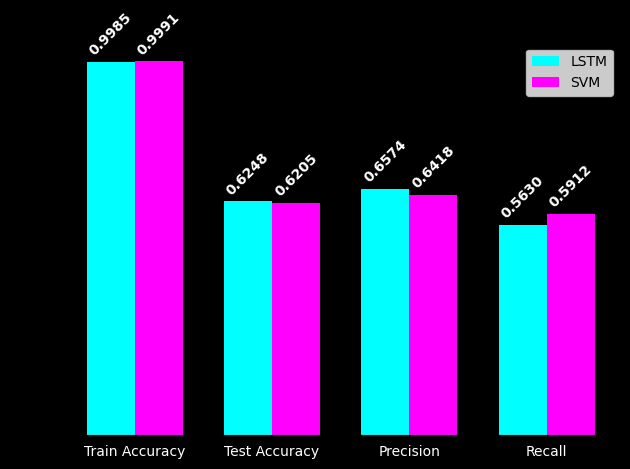

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calculate metrics for LSTM model
lstm_train_accuracy = accuracy_score(y_train, y_train_lstm_pred)
lstm_test_accuracy = accuracy_score(y_test, y_test_lstm_pred)
lstm_precision = precision_score(y_test, y_test_lstm_pred)
lstm_recall = recall_score(y_test, y_test_lstm_pred)

# Calculate metrics for SVM model
svm_train_accuracy = accuracy_score(y_train, y_train_pred_svm_tuned)
svm_test_accuracy = accuracy_score(y_test, y_test_pred_svm_tuned)
svm_precision = precision_score(y_test, y_test_pred_svm_tuned)
svm_recall = recall_score(y_test, y_test_pred_svm_tuned)

# Find maximum values for each metric for both models
max_train_accuracy_lstm = lstm_train_accuracy
max_test_accuracy_lstm = lstm_test_accuracy
max_precision_lstm = lstm_precision
max_recall_lstm = lstm_recall

max_train_accuracy_svm = svm_train_accuracy
max_test_accuracy_svm = svm_test_accuracy
max_precision_svm = svm_precision
max_recall_svm = svm_recall

# Create labels and metrics arrays for both models
labels = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall']
lstm_metrics = [lstm_train_accuracy, lstm_test_accuracy, lstm_precision, lstm_recall]
svm_metrics = [svm_train_accuracy, svm_test_accuracy, svm_precision, svm_recall]
max_values_lstm = [max_train_accuracy_lstm, max_test_accuracy_lstm, max_precision_lstm, max_recall_lstm]
max_values_svm = [max_train_accuracy_svm, max_test_accuracy_svm, max_precision_svm, max_recall_svm]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lstm_metrics, width, label='LSTM', color='cyan')
rects2 = ax.bar(x + width/2, svm_metrics, width, label='SVM', color='magenta')

# Add annotations for maximum values
for i, v in enumerate(max_values_lstm):
    ax.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom', color='white', fontweight='bold', rotation=45)
for i, v in enumerate(max_values_svm):
    ax.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom', color='white', fontweight='bold', rotation=45)

ax.set_ylabel('Scores')
ax.set_title('Comparison of LSTM and SVM Models')
ax.set_xticks(x)
ax.set_xticklabels(labels, color='white')  # Set labels color to white
ax.legend()

# Set background color
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

fig.tight_layout()

plt.show()

# SVM

## initializing SVM and making train test split

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = combined_matrix_combined
y = df['label']# Target variable

In [ ]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the SVM Classifier
svm_classifier = SVC(probability=True, kernel='rbf', random_state=42)

# Training the model on the training set
svm_classifier.fit(X_train, y_train)

# Making predictions on the training set
y_train_pred = svm_classifier.predict(X_train)

# Making predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

## SVM Evaluation

In [ ]:
# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Train Accuracy: 0.802375
Test Accuracy: 0.6215
Precision: 0.6467889908256881
Recall: 0.5567620927936822
F1-score: 0.5984084880636605
Confusion Matrix:
 [[679 308]
 [449 564]]


In [ ]:
from lime import lime_tabular

# Convert feature names to strings
feature_names_str = [str(i) for i in range(X_train.shape[1])]

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.toarray(),
                                              feature_names=feature_names_str,
                                              class_names=['Non-Sarcastic', 'Sarcastic'],
                                              discretize_continuous=True)

# Define function to explain predictions for multiple instances
def explain_predictions(instance_indices):
    for idx in instance_indices:
        instance = X_test.toarray()[idx]
        explanation = explainer.explain_instance(instance, svm_classifier.predict_proba, num_features=10)
        explanation.show_in_notebook()

# Explain predictions for 10 specific instances (e.g., indices 0 to 9)
instance_indices = range(5)
explain_predictions(instance_indices)

# RF Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf

#'labels' is a binary column indicating sarcasm (1) or not sarcasm (0)
X = combined_matrix_combined
y = df["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining and training the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=250, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model on training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Calculate the accuracy of the model on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 1.0
Test Accuracy: 0.6045


**Evaluating the RF Classifier**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.6045
Precision: 0.62117903930131
Recall: 0.5616979269496545
F1-score: 0.589942975635044
Confusion Matrix:
 [[640 347]
 [444 569]]


**Model Interpretability using LIME (Local Interpretable Model-agnostic Explanations):**

In [ ]:
# Check the type of values in the label column
label_types = set()
for val in df["label"]:
    label_types.add(type(val))

print("Types present in label column:", label_types)

# Check if the label column has values other than 0 and 1
unique_values = set(df["label"])
if len(unique_values - {0, 1}) > 0:
    print("Label column has values other than 0 and 1.")
else:
    print("Label column only has values 0 and 1.")


Types present in label column: {<class 'int'>}
Label column only has values 0 and 1.


In [ ]:
from lime import lime_tabular

# Convert feature names to strings
feature_names_str = [str(i) for i in range(X_train.shape[1])]

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(X_train.toarray(),
                                              feature_names=feature_names_str,
                                              class_names=['Non-Sarcastic', 'Sarcastic'],
                                              discretize_continuous=True)

# Define function to explain predictions for multiple instances
def explain_predictions(instance_indices):
    for idx in instance_indices:
        instance = X_test.toarray()[idx]
        explanation = explainer.explain_instance(instance, rf_classifier.predict_proba, num_features=10)
        explanation.show_in_notebook()

# Explain predictions for 5 specific instances
instance_indices = range(5)
explain_predictions(instance_indices)

# Naive Bayes

## Initializing Naive Bayes and doing Train test Split

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # alpha values to try
    'fit_prior': [True, False]  # fit_prior values to try
}

# Clip negative values to 0
X_clipped = combined_matrix_combined.maximum(0)

# Convert to dense array if needed
if sp.issparse(X_clipped):
    X_clipped = X_clipped.toarray()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_clipped, y, test_size=0.2, random_state=42)

# Initialize Naive Bayes classifier
nb_classifier = MultinomialNB()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_nb_classifier = grid_search.best_estimator_

# Predicting the Train and Test set results using the best model
y_train_pred = best_nb_classifier.predict(X_train)
y_test_pred = best_nb_classifier.predict(X_test)

Best Parameters: {'alpha': 0.1, 'fit_prior': False}


## NB Evaluation

In [ ]:
# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Train Accuracy: 0.72375
Test Accuracy: 0.5995
Precision: 0.5990654205607476
Recall: 0.6327739387956565
F1-score: 0.6154584733557369
Confusion Matrix:
 [[558 429]
 [372 641]]


# Comparison of All 4 Models RF classifier, LSTM, SVM and Naive Bayes Classifier

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their corresponding names
models = [rf_classifier, LSTMmodel, svm_classifier, best_nb_classifier]
model_names = ['Random Forest', 'LSTM', 'SVM', 'Naive Bayes']

# Initialize lists to store the metrics
train_accuracy = []
test_accuracy = []
precision = []
recall = []

# Calculate metrics for each model
for model in models:
    if model == LSTMmodel:
        X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        train_accuracy.append(accuracy_score(y_train, np.round(model.predict(X_train_reshaped))))
        test_accuracy.append(accuracy_score(y_test, np.round(model.predict(X_test_reshaped))))
        precision.append(precision_score(y_test, np.round(model.predict(X_test_reshaped))))
        recall.append(recall_score(y_test, np.round(model.predict(X_test_reshaped))))
    else:
        train_accuracy.append(accuracy_score(y_train, model.predict(X_train)))
        test_accuracy.append(accuracy_score(y_test, model.predict(X_test)))
        precision.append(precision_score(y_test, model.predict(X_test)))
        recall.append(recall_score(y_test, model.predict(X_test)))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(models))

# Bar plots
rects1 = ax.bar(index, train_accuracy, bar_width, label='Train Accuracy')
rects2 = ax.bar(index + bar_width, test_accuracy, bar_width, label='Test Accuracy')
rects3 = ax.bar(index + 2 * bar_width, precision, bar_width, label='Precision')
rects4 = ax.bar(index + 3 * bar_width, recall, bar_width, label='Recall')

# Adding labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(model_names)
ax.legend()

# Highlighting maximum values
max_train_acc = max(train_accuracy)
max_test_acc = max(test_accuracy)
max_prec = max(precision)
max_rec = max(recall)

ax.annotate(f'Max Train Acc: {max_train_acc:.3f}', xy=(train_accuracy.index(max_train_acc), max_train_acc),
            xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='angle3'))
ax.annotate(f'Max Test Acc: {max_test_acc:.3f}', xy=(test_accuracy.index(max_test_acc), max_test_acc),
            xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='angle3'))
ax.annotate(f'Max Precision: {max_prec:.3f}', xy=(precision.index(max_prec), max_prec),
            xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='angle3'))
ax.annotate(f'Max Recall: {max_rec:.3f}', xy=(recall.index(max_rec), max_rec),
            xytext=(-20, 10), textcoords='offset points', arrowprops=dict(arrowstyle='->', connectionstyle='angle3'))

plt.tight_layout()
plt.show()

"import matplotlib.pyplot as plt\nimport numpy as np\n\n# Define the models and their corresponding names\nmodels = [rf_classifier, LSTMmodel, svm_classifier, best_nb_classifier]\nmodel_names = ['Random Forest', 'LSTM', 'SVM', 'Naive Bayes']\n\n# Initialize lists to store the metrics\ntrain_accuracy = []\ntest_accuracy = []\nprecision = []\nrecall = []\n\n# Calculate metrics for each model\nfor model in models:\n    if model == LSTMmodel:\n        X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])\n        X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])\n        train_accuracy.append(accuracy_score(y_train, np.round(model.predict(X_train_reshaped))))\n        test_accuracy.append(accuracy_score(y_test, np.round(model.predict(X_test_reshaped))))\n        precision.append(precision_score(y_test, np.round(model.predict(X_test_reshaped))))\n        recall.append(recall_score(y_test, np.round(model.predict(X_test_reshaped))))\n    else:\n        